# 참조

In [4]:
import cv2
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
from skimage import data
import urllib.request

# 1. 해리스 코너 포인트 검출

## 해리스 코너 검출 방법

### 구조 텐서 $M$을 함수 $c(x, y)$에서 유도하는 과정

  #### 1. 윈도우 내의 변화량 함수 $c(x, y)$

  * 이미지의 코너를 검출하기 위해, 우리는 이미지의 한 점 $(x, y)$ 주위의 픽셀 값의 변화량을 평가합니다. 이 변화량은 주어진 윈도우 $W$ 내에서의 변화량으로 표현할 수 있습니다.

  * 변화량 함수 $c(x, y)$는 윈도우 $W$ 내에서 이동 벡터 $(\Delta x, \Delta y)$에 의해 변위된 이미지의 변화량을 나타냅니다. 일반적으로 다음과 같이 정의됩니다:

  $$
  c(x, y) = \sum_{x', y' \in W} w(x', y') \left[I(x' + \Delta x, y' + \Delta y) - I(x', y')\right]^2
  $$

  * 여기서 $I(x, y)$는 이미지의 픽셀 값, $w(x', y')$는 윈도우 $W$의 가우시안 형태의 가중치를 의미합니다.

  ---

  #### 2. 테일러 급수 전개

  * 이미지 $I(x + \Delta x, y + \Delta y)$를 테일러 급수로 전개하면 다음과 같습니다:

  $$
  I(x + \Delta x, y + \Delta y) \approx I(x, y) + I_x \Delta x + I_y \Delta y
  $$

  * 여기서 $I_x$와 $I_y$는 각각 $x$와 $y$에 대한 이미지의 기울기입니다.

  ---

  #### 3. 변화량 함수의 근사

  * 이제, 변화량 함수를 테일러 급수를 사용하여 근사화할 수 있습니다:

  $$
  c(x, y) \approx \sum_{x', y' \in W} w(x', y') \left[I(x', y') + I_x \Delta x + I_y \Delta y - I(x', y')\right]^2
  $$

  * 이를 단순화하면:

  $$
  c(x, y) \approx \sum_{x', y' \in W} w(x', y') \left(I_x \Delta x + I_y \Delta y\right)^2
  $$

  $$
  \downarrow
  $$

  $$
  c(x, y) \approx \sum_{x', y' \in W} w(x', y') \left(I_x^2 \Delta x^2 + 2 I_x I_y \Delta x \Delta y + I_y^2 \Delta y^2\right)
  $$

  * 다음 식을 행렬로 변환시킬 수 있습니다:

  $$
  I_x^2 \Delta x^2 + 2 I_x I_y \Delta x \Delta y + I_y^2 \Delta y^2
  $$

  $$
  \downarrow
  $$

  $$
  \begin{bmatrix}
  \Delta x & \Delta y
  \end{bmatrix}
  \begin{bmatrix}
  I_x^2 & I_x I_y \\
  I_x I_y & I_y^2
  \end{bmatrix}
  \begin{bmatrix}
  \Delta x \\
  \Delta y
  \end{bmatrix}
  $$

  ---

  #### 4. 구조 텐서 $M$

  * 구조 텐서 $M$은 이미지의 기울기 정보를 포함하는 2x2 행렬입니다. 이를 사용하여 위의 합을 행렬 형식으로 표현할 수 있습니다:

  $$
  c(x, y) =
  \begin{bmatrix}
  \Delta x & \Delta y
  \end{bmatrix}
  \left( \sum_{x', y' \in W} w(x', y')
  \begin{bmatrix}
  I_x^2 & I_x I_y \\
  I_x I_y & I_y^2
  \end{bmatrix}
  \right)
  \begin{bmatrix}
  \Delta x \\
  \Delta y
  \end{bmatrix}
  $$

  * 여기서 구조 텐서 $M$은 다음과 같이 정의됩니다:

  $$
  M = \sum_{x', y' \in W} w(x', y')
  \begin{bmatrix}
  I_x^2 & I_x I_y \\
  I_x I_y & I_y^2
  \end{bmatrix}
  $$

  * 따라서, 변화량 함수 $c(\Delta x, \Delta y)$는 다음과 같이 표현될 수 있습니다:

  $$
  c(x, y) =
  \begin{bmatrix}
  \Delta x & \Delta y
  \end{bmatrix}
  M
  \begin{bmatrix}
  \Delta x \\
  \Delta y
  \end{bmatrix}
  $$


---


#### 5.1 구조 텐서 $M$의 고유값

  구조 텐서 $M$의 고유값은 이미지의 국소적 변화율을 나타내며, 코너 검출의 핵심 요소입니다.

  - `코너 (Corner)`: 고유값 $\lambda_1$과 $\lambda_2$가 둘 다 크다면, 이는 해당 지역에서 $x$ 방향과 $y$ 방향 모두에서 큰 변화가 있다는 것을 의미합니다. 즉, 두 방향 모두에서 이미지의 변화가 크다는 것이므로, 이 지역은 코너입니다.

  - `에지 (Edge)`: 고유값 중 하나가 크고 다른 하나가 작다면, 이는 해당 지역에서 한 방향으로는 큰 변화가 있지만, 다른 방향으로는 변화가 적다는 것을 의미합니다. 즉, 에지에서는 이미지의 기울기가 한 방향으로는 매우 크고, 다른 방향으로는 거의 변화가 없기 때문에, 구조 텐서의 고유값 중 하나는 크고 다른 하나는 작게 됩니다.

  - `평탄한 영역 (Flat Region)`: 고유값 $\lambda_1$과 $\lambda_2$가 둘 다 작다면, 이는 해당 지역에서 $x$ 방향과 $y$ 방향 모두에서 변화가 거의 없다는 것을 의미합니다. 즉, 이 지역은 평탄하고 큰 기울기 변화가 없으므로 평탄한 영역입니다.


---

#### 5.2 구조 텐서 $M$의 고유값 구하기 (선형대수학 : 고유값과 고유벡터 참고)

  #### 5.2.1 구조 텐서 $M$의 형태

  * 구조 텐서 $M$은 다음과 같은 일반적인 형태를 가집니다:

  $$
  M = \begin{bmatrix}
  a & b \\
  b & c
  \end{bmatrix}
  $$

  * 여기서 각 원소는 다음과 같이 정의됩니다:

  $$
  a = \sum_{x', y' \in W} w(x', y') I_x^2
  $$

  $$
  b = \sum_{x', y' \in W} w(x', y') I_x I_y
  $$

  $$
  c = \sum_{x', y' \in W} w(x', y') I_y^2
  $$



  #### 5.2.2. 특성 방정식 설정

  * 고유값 $\lambda$를 구하기 위해 특성 방정식을 설정합니다. 먼저, $M - \lambda I$를 구합니다:

  $$
  M - \lambda I = \begin{bmatrix}
  a - \lambda & b \\
  b & c - \lambda
  \end{bmatrix}
  $$



  #### 5.2.3. 행렬식 계산

  * 행렬식(determinant)을 계산하여 특성 방정식을 구합니다:

  $$
  \det(M - \lambda I) = \begin{vmatrix}
  a - \lambda & b \\
  b & c - \lambda
  \end{vmatrix}
  $$

  $$
  = (a - \lambda)(c - \lambda) - b^2
  $$

  따라서, 특성 방정식은 다음과 같습니다:

  $$
  \lambda^2 - (a + c) \lambda + (ac - b^2) = 0
  $$

  #### 5.2.4. 근의 공식

  * 위 특성 방정식 $\lambda^2 - (a + c) \lambda + (ac - b^2) = 0$을 풀기 위해 근의 공식을 사용합니다. 근의 공식은 다음과 같습니다:

  $$
  \lambda = \frac{(a + c) \pm \sqrt{(a + c)^2 - 4(ac - b^2)}}{2}
  $$

---

#### 6. 코너 응답 함수 계산

  * 코너 응답 함수 $R$은 구조 텐서 $M$의 고유값을 기반으로 계산됩니다. 구조 텐서 $M$의 고유값 $\lambda_1$과 $\lambda_2$는 이미지의 국소적 변화율을 나타내며, 이를 이용해 $R$ 값을 다음과 같이 정의합니다:

  $$
  R = \det(M) - k (\text{trace}(M))^2
  $$

  * 여기서 $\det(M)$은 행렬 $M$의 행렬식이고, $\text{trace}(M)$은 행렬 $M$의 대각합입니다. $k$는 경험적으로 정해지는 상수로, 일반적으로 $0.04$에서 $0.06$ 사이의 값을 사용합니다.

  * 행렬의 고유값에 관한 중요한 성질은 다음과 같습니다:

   - 행렬 $M$의 행렬식은 $M$의 고유값들의 곱입니다. 즉,
   $$
   \det(M) = \lambda_1 \lambda_2
   $$
   여기서 $\lambda_1$과 $\lambda_2$는 $M$의 고유값입니다.

   - 행렬 $M$의 대각합(trace)은 $M$의 고유값들의 합입니다. 즉,
   $$
   \text{trace}(M) = \lambda_1 + \lambda_2
   $$

  $$
  \det(M) = ac - b^2
  $$

  $$
  \text{trace}(M) = a + c
  $$

  따라서,

  $$
  R = (ac - b^2) - k (a + c)^2
  $$

  이 공식은 코너 응답 함수 $R$을 계산하는 데 사용됩니다. 여기서 $k$는 경험적으로 정해진 상수입니다.







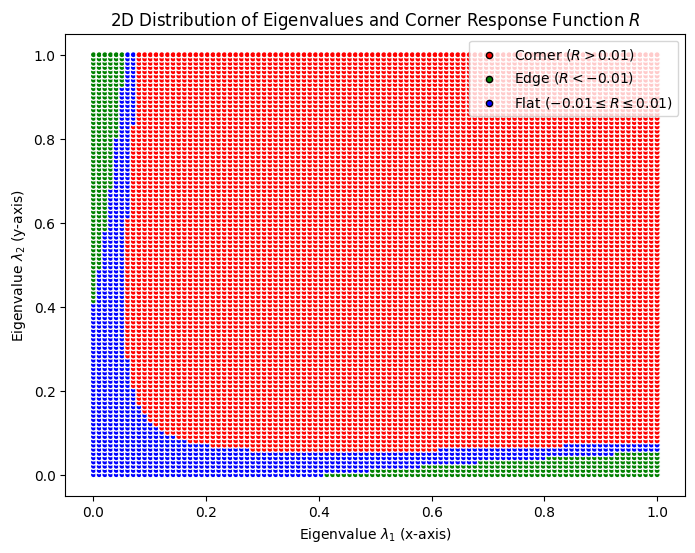

In [ ]:
# 고유값 범위 설정
lambda1 = np.linspace(0, 1, 100)
lambda2 = np.linspace(0, 1, 100)

# 그리드 생성
L1, L2 = np.meshgrid(lambda1, lambda2)

# 상수 k 설정
k = 0.06

# 코너 응답 함수 R 계산
R = (L1 * L2) - k * (L1 + L2)**2

# 색상 기준 정의
positive_threshold = 0.01
negative_threshold = -0.01

# 색상 배열을 정의합니다.
colors = np.full(L1.shape, 'b')  # 기본 색상은 'b' (파랑)
colors[R > positive_threshold] = 'r'  # 코너는 빨강
colors[R < negative_threshold] = 'g'  # 에지는 초록
colors[(R <= positive_threshold) & (R >= negative_threshold)] = 'b'  # 평탄한 영역은 파랑

# 플롯 설정
plt.figure(figsize=(8, 6))

# 2D 플롯
# 색상 팔레트 설정 (seaborn 사용)
plt.scatter(L1, L2, c=colors.flatten(), edgecolors='w', s=20)

# 레이블과 제목 추가
plt.xlabel('Eigenvalue $\lambda_1$ (x-axis)')
plt.ylabel('Eigenvalue $\lambda_2$ (y-axis)')
plt.title('2D Distribution of Eigenvalues and Corner Response Function $R$')

# 범례 추가
# zip 함수는 두 개 이상의 리스트를 묶어 튜플로 만듭니다. 이 경우, 색상 리스트 ['r', 'g', 'b']와 레이블 리스트 legend_labels를 튜플로 묶습니다.

legend_labels = ['Corner ($R > 0.01$)', 'Edge ($R < -0.01$)', 'Flat ($-0.01 \leq R \leq 0.01$)']
for color, label in zip(['r', 'g', 'b'], legend_labels):
    plt.scatter([], [], c=color, edgecolors='k', s=20, label=label)

plt.legend()
plt.show()

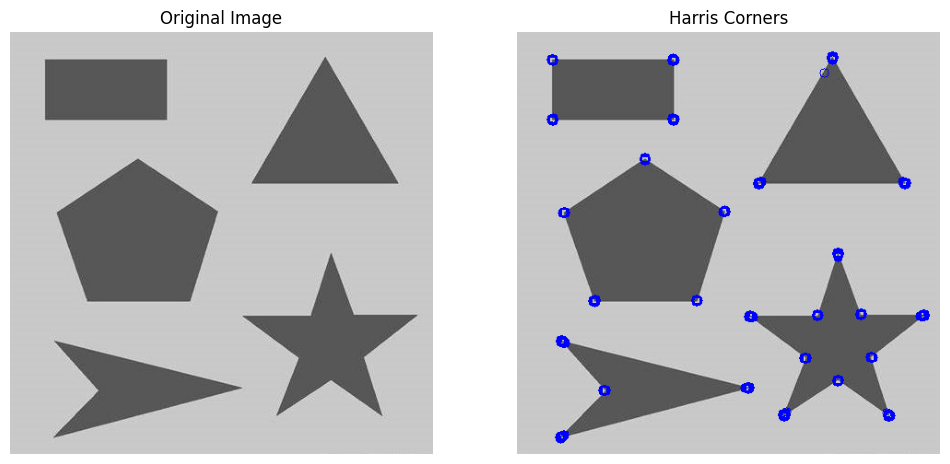

In [ ]:
def harris_corner_detection(image, k=0.04, threshold=0.01):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)  # Convert to float32 for precision in calculations

    # Calculate the x and y gradients using Sobel operator
    Ix = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

    # Calculate products of gradients
    Ixx = cv2.multiply(Ix, Ix)
    Iyy = cv2.multiply(Iy, Iy)
    Ixy = cv2.multiply(Ix, Iy)

    # Apply Gaussian filter to the gradient products (equivalent to Gaussian windowing)
    Sxx = cv2.GaussianBlur(Ixx, (3, 3), sigmaX=1, sigmaY=1)
    Syy = cv2.GaussianBlur(Iyy, (3, 3), sigmaX=1, sigmaY=1)
    Sxy = cv2.GaussianBlur(Ixy, (3, 3), sigmaX=1, sigmaY=1)

    # Calculate the response of the detector at each pixel
    detM = cv2.subtract(cv2.multiply(Sxx, Syy), cv2.multiply(Sxy, Sxy))
    traceM = cv2.add(Sxx, Syy)
    R = cv2.subtract(detM, k * cv2.multiply(traceM, traceM))

    # Threshold to find corners
    R_max = R.max()
    corners = np.zeros_like(gray)
    corners[R > threshold * R_max] = 255

    return corners, R

# Load an image
image = cv2.imread('drive/MyDrive/OIP.jpg')

# Perform Harris corner detection
corners, R = harris_corner_detection(image)

# Find corner positions using np.argwhere
corner_positions = np.argwhere(corners == 255)

# Overlay the corners on the original image by drawing circles
overlay = image.copy()
for pos in corner_positions:
    cv2.circle(overlay, (pos[1], pos[0]), 5, (255, 0, 0), 1)  # Red circles

# Create subplots to show the original image and the corners
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title('Harris Corners')
plt.axis('off')

plt.show()


## cv2.preCornerDetect() 코너점 검출

 - cv2.preCornerDetect
  * cv2.preCornerDetect는 코너를 감지하기 위한 초기 단계로, 일반적으로 Harris 또는 다른 코너 감지 알고리즘의 전처리 단계로 사용됩니다.

  * 이 함수는 입력 이미지의 특징을 기반으로 각 픽셀에 대해 감지된 코너의 강도를 반환합니다.

    출력: 이 함수의 출력은 코너 응답 이미지입니다. 이 응답 값은 코너의 강도를 나타내며, 높을수록 코너일 가능성이 큽니다.

---

- findLocalMaxima
  * findLocalMaxima 함수는 cv2.preCornerDetect의 결과에서 지역 최대값을 찾아 실제 코너 위치를 결정합니다.

    `팽창 연산 (Dilation)`:

      cv2.dilate 함수를 사용하여 이미지를 팽창시킵니다. 3 * 3 사각형 이웃(지역)에서 최대값을 dilate에 계산합니다.

    `지역 최대값 계산`:

      팽창된 이미지와 원본 이미지를 비교하여 지역 최대값을 결정합니다. 즉, dilated == preCorner는 원본 이미지에서 지역 최대값을 찾습니다.
      (최대가 아니지만 지역 최대값으로 변경된 부분은 False, 지역 최대값은 True)

    `침식 연산 (Erosion)`:

      cv2.erode 함수를 사용하여 이미지를 침식시킵니다. 3 * 3 사각형 이웃(지역)에서 최소값을 erode에 계산합니다.
    
    `지역 최대값의 추가 조건`:

      코너 응답 값이 주변보다 강해야 합니다. 따라서 지역 최소값보다 큰 값이어야 합니다. preCorner > erode는 원본 이미지에서 지역 최소값보다 큰 영역을 찾습니다. (지역 최소값은 False, 지역 최소값보다 큰 부분은 True)
    
     `최종 로컬 최대값 계산`:

      위 두 조건을 논리곱(&)하여 최종적으로 강한 코너를 결정합니다. 이는 코너 응답이 원본 이미지의 최대값이며 동시에 주변보다 강한지를 확인합니다.


---


In [ ]:
def findLocalMaxima(image):
    # 모폴로지 커널 크기 및 모양 결정
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))

    # 팽창 연산
    dilated = cv2.dilate(image, kernel, iterations=1)

    # 로컬 최대값 계산
    localMax = (dilated == image)

    # 침식 연산
    erode = cv2.erode(image, kernel, iterations=1)

    # 로컬 최대값의 추가 조건
    localMax2 = image > erode

    # 최종 로컬 최대값 계산
    localMax3 = localMax & localMax2

    # 인덱스 배열 생성
    points = np.argwhere(localMax3 == True)
    points[:, [0, 1]] = points[:, [1, 0]]  # x, y 변환

    return points, dilated, erode, localMax, localMax2, localMax3

def Visualization(image, axs, title):
    axs.imshow(image, cmap='gray')
    axs.set_title(title)
    axs.axis('off')

def create_square(image_size, square_size):

    # 빈 이미지 생성 (흰색 배경)
    image = np.ones(image_size, dtype=np.uint8) * 255

    # 중앙에 검은색 사각형 그리기
    start_x = (image_size[1] - square_size) // 2
    start_y = (image_size[0] - square_size) // 2
    end_x = start_x + square_size
    end_y = start_y + square_size

    image[start_y:end_y, start_x:end_x] = 0  # 검은색 사각형

    return image

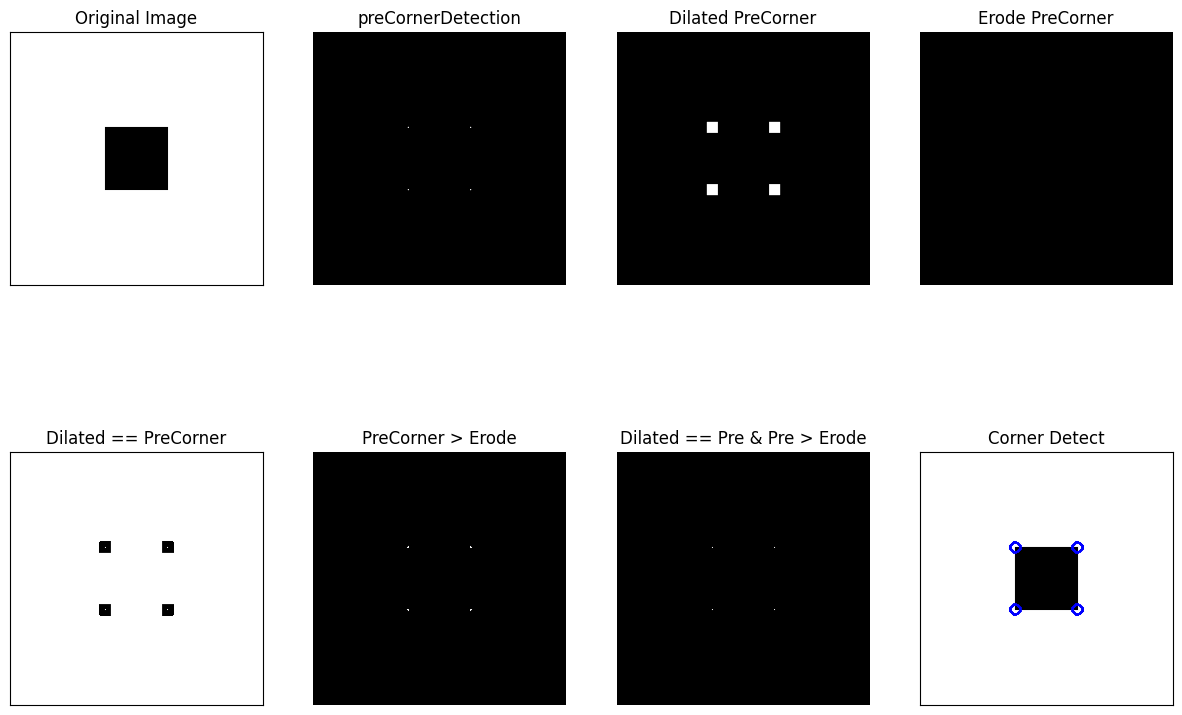

In [ ]:

# 이미지 크기 및 사각형 크기 설정
image_size = (256, 256)
square_size = 64

# 이미지 생성
image = create_square(image_size, square_size)


res = cv2.preCornerDetect(image, ksize=3)
ret, res2 = cv2.threshold(np.abs(res), 0.1, 0, cv2.THRESH_TOZERO)

# 로컬 최대값 찾기
corners, dilated, erode, localMax, localMax2, localMax3 = findLocalMaxima(res2)

# Convert to BGR for color display
dst = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Draw circles at corner points
for x, y in corners:
    cv2.circle(dst, (x, y), 5, (0, 0, 255), 2)

fig, axs = plt.subplots(2, 4, figsize=(15, 10))

Visualization(image, axs[0, 0], 'Original Image')
axs[0, 0].axis('on')
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])

Visualization(res2, axs[0, 1], 'preCornerDetection')

Visualization(dilated, axs[0, 2], 'Dilated PreCorner')

Visualization(erode, axs[0, 3], 'Erode PreCorner')

Visualization(localMax, axs[1, 0], 'Dilated == PreCorner')
axs[1, 0].axis('on')
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])

Visualization(localMax2, axs[1, 1], 'PreCorner > Erode')

Visualization(localMax3, axs[1, 2], 'Dilated == Pre & Pre > Erode')

Visualization(dst, axs[1, 3], 'Corner Detect')
axs[1, 3].axis('on')
axs[1, 3].set_xticks([])
axs[1, 3].set_yticks([])

plt.show()



## cornerEigenValsVecs() 함수

  - cv2.cornerEigenValsAndVecs 함수
    * 각 픽셀의 코너 응답을 분석하여 국소적인 구조 정보를 제공합니다.
    * 이 함수는 주어진 이미지의 코너 응답을 계산하여 각 픽셀에 대한 고유값(eigenvalues)과 고유벡터(eigenvectors)를 반환합니다.
  
  - 함수 정의
    
    `retval = cv2.cornerEigenValsAndVecs(src, blockSize, ksize, borderType=None)`
  - 매개변수
    * src: 입력 이미지. 일반적으로 그레이스케일 이미지입니다.

    * blockSize: 각 픽셀에 대해 고유값과 고유벡터를 계산할 때 고려할 윈도우의 크기입니다. 이 크기만큼의 이웃 픽셀을 사용하여 계산합니다.

    * ksize: Sobel 미분기를 사용하여 이미지의 1차 미분을 계산할 때 사용할 커널 크기입니다.

    * borderType: 가장자리 픽셀에 대한 경계 처리 방식입니다. 기본값은 cv2.BORDER_DEFAULT입니다.


res.shape (256, 256, 6)
eigen.shape (6, 256, 256)
len(corners) =  4


[]

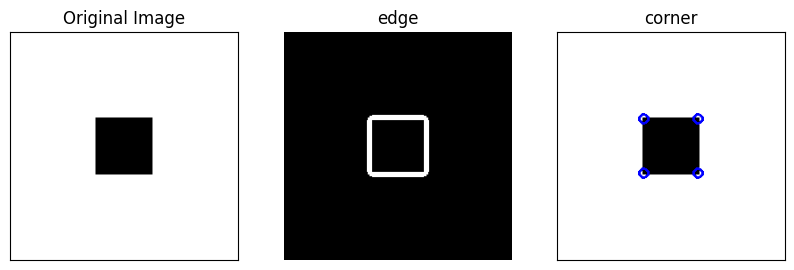

In [ ]:
res = cv2.cornerEigenValsAndVecs(image, blockSize=5, ksize=3)
print('res.shape', res.shape) # row * colum * channel
eigen = cv2.split(res)  #채널 수 : 고유값 2개 + 고유 벡터 좌표 2개 총 6개
eigen = np.array(eigen)
print('eigen.shape', eigen.shape) # channel * row * colum

#2
T = 0.2
ret, edge = cv2.threshold(eigen[0], T, 255, cv2.THRESH_BINARY) #고유값 1번
edge = edge.astype(np.uint8)

#3
#두 고유값은 보통 크기 순으로 정렬되어 eigen[0]과 eigen[1]에 저장
#eigen[0] > eigen[1]

corners = np.argwhere(eigen[1] > T) #고유값 2번
corners[:, [0, 1]] = corners[:, [1, 0]]  # x, y 변환
print('len(corners) = ' , len(corners))

dst = image.copy()

# Convert to BGR for color display
dst = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

for x, y in corners:
    cv2.circle(dst, (x, y), 5, (0, 0, 255), 2)

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
Visualization(image, axs[0], 'Original Image')
axs[0].axis('on')
axs[0].set_xticks([])
axs[0].set_yticks([])

Visualization(edge, axs[1], 'edge')

Visualization(dst, axs[2], 'corner')
axs[2].axis('on')
axs[2].set_xticks([])
axs[2].set_yticks([])




## cv2.cornerMinEigenVal() 함수

eigen.shape (256, 256)


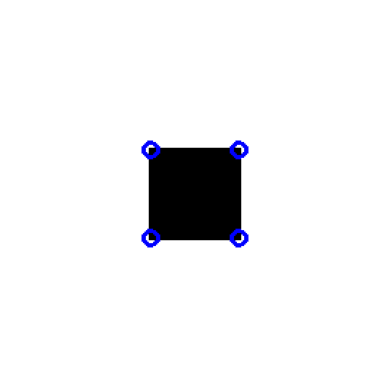

In [ ]:
eigen = cv2.cornerMinEigenVal(image, blockSize=5)
print('eigen.shape', eigen.shape) # 작은 고유값만이 출력

T = 0.2
corners = np.argwhere(eigen > T)
corners[:, [0, 1]] = corners[:, [1, 0]]  # x, y 변환

dst = image.copy()

# Convert to BGR for color display
dst = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

for x, y in corners:
    cv2.circle(dst, (x, y), 5, (0, 0, 255), 2)

plt.imshow(dst, cmap='gray')
plt.axis('off')
plt.show()

## cv2.cornerHarris() 함수와 cv2.SubPix() 함수

corners = [[ 95.558426  95.558426]
 [159.44157   95.558426]
 [ 95.558426 159.44157 ]
 [159.44157  159.44157 ]]
corners2 = [[ 95.558426  95.558426]
 [159.44157   95.558426]
 [ 95.558426 159.44157 ]
 [159.44157  159.44157 ]]


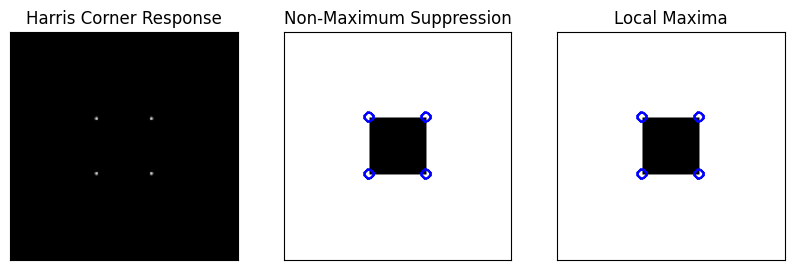

In [ ]:
# image = cv2.imread('drive/MyDrive/OIP.jpg')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 이미지 크기 및 사각형 크기 설정
image_size = (256, 256)
square_size = 64

# 이미지 생성
image = create_square(image_size, square_size)

image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)[1]

# Calculate Harris corner response
res = cv2.cornerHarris(image, blockSize=5, ksize=3, k=0.01)
ret, res = cv2.threshold(np.abs(res), 0.01, 0, cv2.THRESH_TOZERO)

# res의 원소 값들을 0 ~ 255 사이의 값으로 정규화
res8 = cv2.normalize(res, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
Visualization(res8, axs[0], 'Harris Corner Response')
axs[0].axis('on')
axs[0].set_xticks([])
axs[0].set_yticks([])

def findLocalMaxima2(res, threshold=0.2):
    # res를 numpy 배열로 변환
    res = np.array(res)

    # 응답의 최대값을 기준으로 임계값 설정
    max_val = np.max(res)
    threshold_value = threshold * max_val

    # 지역 최대값을 찾기 위해 Non-Maximum Suppression 적용
    corners = []
    for y in range(2, res.shape[0] - 1):
        for x in range(2, res.shape[1] - 1):
            if res[y, x] > threshold_value:
                # 현재 픽셀과 주변 15픽셀 비교
                if (res[y, x] == res[y-2:y+2, x-2:x+2].max()):
                    corners.append((x, y))

    # 코너를 NumPy 배열로 변환
    corners = np.array(corners)

    return corners

# Find local maxima
corners = findLocalMaxima2(res)

# Convert corners to float32 for cornerSubPix
corners = corners.astype(np.float32, order='C')

# Define termination criteria
term_crit = (cv2.TERM_CRITERIA_MAX_ITER | cv2.TERM_CRITERIA_EPS, 30, 0.001)

# Refine corner locations
corners = cv2.cornerSubPix(image, corners, (5, 5), (-1, -1), term_crit)

# Copy the image to draw corners
dst = image.copy()
dst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)

# Draw detected corners
for x, y in corners:
    cv2.circle(dst, (int(x), int(y)), 5, (0, 0, 255), 2)

Visualization(dst, axs[1], 'Non-Maximum Suppression')
axs[1].axis('on')
axs[1].set_xticks([])
axs[1].set_yticks([])


# Find local maxima
res = cv2.threshold(np.abs(res), 0.2 * res.max(), 0, cv2.THRESH_TOZERO)[1]
corners2 = findLocalMaxima(res)[0]

# Convert corners to float32 for cornerSubPix
corners2 = corners2.astype(np.float32, order='C')

# Refine corner locations
corners2 = cv2.cornerSubPix(image, corners2, (5, 5), (-1, -1), term_crit)

print('corners =' , corners)
print('corners2 =' , corners2)

# Copy the image to draw corners
dst2 = image.copy()
dst2 = cv2.cvtColor(dst2, cv2.COLOR_GRAY2BGR)

# Draw detected corners
for x, y in corners2:
    cv2.circle(dst2, (int(x), int(y)), 5, (0, 0, 255), 2)

Visualization(dst2, axs[2], 'Local Maxima')
axs[2].axis('on')
axs[2].set_xticks([])
axs[2].set_yticks([])

plt.show()

## cv2.connectedComponentsWithStats() 함수로 팽창 영역의 중심 찾는 방법

1. cv2.cornerHarris()로 gray 영상에서 각 화소 이웃에 의한 2 * 2 공분산 행렬 M의 Harris 반응값 R을 res에 계산한다. res.shape -> (512, 512)

2. cv2.dilate()로 res에 3 * 3 사각형 커널을 사용하여 팽창 연산으로 지역 최대값을 res에 계산한다. cv2.threshold()로 임계값을 설정하여 임계값 이상은 255가 되도록 하여 이진영상을 res에 저장한다. (thres = 최대값의 0.01배)

3. cv2.connectedComponentsWithStats()로 이진 영상 res8를 레이블링하여 레이블 개수 ret, 레이블 정보 labels, 통계 정보 Stats, 중심점 centroids를 계산한다. (배경을 포함하기 때문에 ret = 5, 배경이 아닌 레이블의 중심을 코너점으로 검출)

4. cv2.cornerSubPix()로 centroid를 부화소 수준으로 계산하여 corners에 저장한다. 그리고 corners 좌표를 중심으로 하는 원을 그린다.

In [ ]:
#1
# 이미지 크기 및 사각형 크기 설정
image_size = (256, 256)
square_size = 64

# 이미지 생성
image = create_square(image_size, square_size)
res = cv2.cornerHarris(image, blockSize=5, ksize=3, k=0.01)

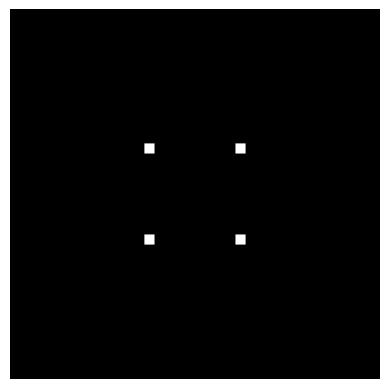

In [ ]:
#2
res = cv2.dilate(res, None, iterations=1)
ret, res = cv2.threshold(res, 0.01 * res.max(), 255, cv2.THRESH_BINARY)
res8 = np.uint8(res)

plt.imshow(res8, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
#3
ret, labels, stats, centroid = cv2.connectedComponentsWithStats(res8)
print('centroids.shape=', centroid.shape)
print('centroids=', centroid)

centroid = centroid.astype(np.float32)

centroids.shape= (5, 2)
centroids= [[127.5 127.5]
 [ 96.   96. ]
 [159.   96. ]
 [ 96.  159. ]
 [159.  159. ]]


In [ ]:
#4
term_crit = (cv2.TERM_CRITERIA_MAX_ITER | cv2.TERM_CRITERIA_EPS, 30, 0.001)
corners = cv2.cornerSubPix(image, centroid, (5, 5), (-1, -1), term_crit)

print('corners=', corners)

corners= [[127.5     127.5    ]
 [ 95.55833  95.55833]
 [159.44167  95.55833]
 [ 95.55833 159.44167]
 [159.44168 159.44168]]


corners= [[128. 128.]
 [ 96.  96.]
 [159.  96.]
 [ 96. 159.]
 [159. 159.]]


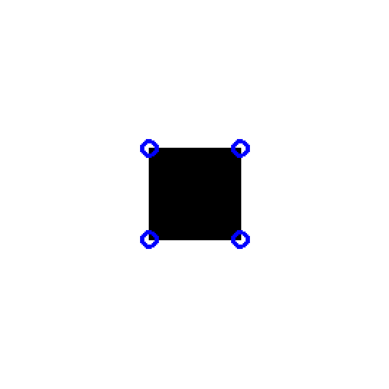

In [ ]:
#5
corners = np.round(corners)
print('corners=', corners)

dst = image.copy()

dst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)

for x, y in corners[1:]: #배경 빼고
    cv2.circle(dst, (int(x), int(y)), 5, (0, 0, 255), 2)

plt.imshow(dst, cmap='gray')
plt.axis('off')
plt.show()

## cv2.goodFeaturesToTrack() 코너점 검출

* 함수 구성
cv2.goodFeaturesToTrack( image, maXcorners, qualityLevel, minDistance[, corners[, mask[, blockSize[, useHarrisDetector[, k]]]]]) -> corners

  - image: 입력 이미지 (흑백 이미지)

  - maxCorners: 반환할 코너의 최대 개수

  - qualityLevel: 코너 품질의 최소 허용 수준 (0과 1 사이의 값)

  - minDistance: 반환된 코너 간의 최소 거리

  - corners (옵션): 코너 위치를 반환할 배열

  - mask (옵션): 코너 탐색을 제한할 마스크 이미지

  - blockSize (옵션): 코너 검출에 사용할 이웃 픽셀 영역의 크기

  - useHarrisDetector (옵션): True이면 Harris 코너 감지기를 사용하고, False이면 Shi-Tomasi 방법을 사용

  - k (옵션): Harris 코너 검출기에서 사용하는 자유 매개변수 (Harris 감지기 방정식에서 사용하는 상수)


* 코드 예제

  1. cv2.goodFeaturesToTrack() 함수에 적절한 인수를 적용하여 코너점을 corners에 검출한다. ( maxCorners가 5인 경우 corners.shape는 (5, 1, 2) 이다. )

In [ ]:
#1
# 이미지 크기 및 사각형 크기 설정
# image_size = (256, 256)
# square_size = 64

# # 이미지 생성
# image = create_square(image_size, square_size)

image = cv2.imread('drive/MyDrive/OIP.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

K = 25

#corners3이라 한 이유는 이전 corners에 append 시키기 때문임.
corners3 = cv2.goodFeaturesToTrack(image, maxCorners=K, qualityLevel=0.01, minDistance=10)

print('corners3.shape=', corners3.shape)

corners3.shape= (25, 1, 2)


In [ ]:
#2
corners2 = cv2.goodFeaturesToTrack(image, maxCorners=K, qualityLevel=0.01, minDistance=10, useHarrisDetector=True, k=0.04)

print('corners2.shape=', corners2.shape)

corners2.shape= (25, 1, 2)


corners = [[263. 163.]
 [420. 163.]
 [342.  27.]
 [169.  94.]
 [169.  30.]
 [290. 415.]
 [ 39.  94.]
 [ 38.  30.]
 [441. 307.]
 [348. 240.]
 [253. 308.]
 [ 84. 291.]
 [224. 195.]
 [ 95. 389.]
 [403. 416.]
 [ 48. 335.]
 [194. 291.]
 [325. 306.]
 [373. 306.]
 [ 48. 439.]
 [251. 386.]
 [312. 353.]
 [ 51. 196.]
 [385. 353.]
 [139. 138.]]

corners2 = [[263. 163.]
 [420. 163.]
 [342.  28.]
 [169.  94.]
 [169.  30.]
 [348. 241.]
 [290. 415.]
 [440. 307.]
 [ 38.  94.]
 [ 84. 291.]
 [ 38.  30.]
 [253. 308.]
 [ 95. 389.]
 [225. 195.]
 [194. 291.]
 [ 49. 336.]
 [373. 306.]
 [325. 307.]
 [402. 414.]
 [ 48. 439.]
 [250. 386.]
 [312. 353.]
 [ 51. 195.]
 [384. 353.]
 [139. 138.]]

False


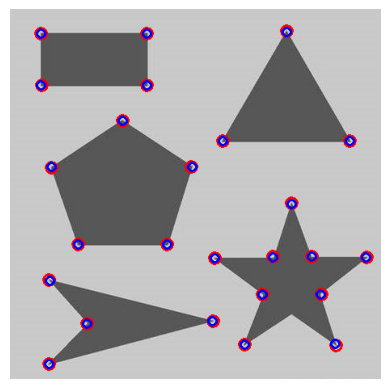

In [ ]:
#3
dst = image.copy()

dst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)

#-1: 배열의 크기 중 하나를 -1로 지정하면, 이 값은 자동으로 계산됩니다.
corners3 = corners3.reshape(-1, 2) #corners.shape = (25, 2)
corners2 = corners2.reshape(-1, 2)

print(f'corners = {corners3}\n')
print(f'corners2 = {corners2}\n')

for x,y in corners3:
    cv2.circle(dst, (int(x), int(y)), 7, (255, 0, 0), 2)


for x,y in corners2:
    cv2.circle(dst, (int(x), int(y)), 5, (0, 0, 255), 2)

print(corners3 is corners2)

plt.imshow(dst, cmap='gray')
plt.axis('off')
plt.show()
#

# 2. 체스보드 코너점 검출

## cv2.findChessboardCorners()

### 함수 정의
- cv2.findChessboardCorners(iamge, patternSize[, corners[, flags]]) -> retval, corners

### 인수:
- image: 체스보드 (보통 흑백)이미지.

- patternSize: 체스보드 패턴의 내부 코너 개수를 나타내는 튜플. (여기서 내부 코너는 체스보드의 격자 선이 교차하는 점을 말함.)

- corners (옵션): 반환된 코너 좌표를 저장하기 위한 배열.만약 제공되지 않으면, 함수가 코너 좌표를 자동으로 생성하고 반환함.

- flags (옵션): 코너 검출에 사용되는 플래그. 여러 가지 플래그를 조합하여 사용.
  주요 플래그:
  * cv2.CALIB_CB_ADAPTIVE_THRESH: 적응형 임계값을 사용.

  * cv2.CALIB_CB_NORMALIZE_IMAGE: 코너 검출 전에 이미지를 정규화.

  * cv2.CALIB_CB_FILTER_QUADS: 모든 쿼드가 발견되었는지 확인.

  * cv2.CALIB_CB_FAST_CHECK: 빠른 체크를 수행. 체스보드 패턴이 없을 가능성이 높은 이미지를 빨리 거르는 데 유용함.

### 반환값:
- retval: 코너를 성공적으로 찾으면 True, 그렇지 않으면 False를 반환.
- corners: 발견된 코너의 좌표를 담고 있는 배열.

### 함수 예제:



Corners found!
corners.shape= (54, 1, 2)


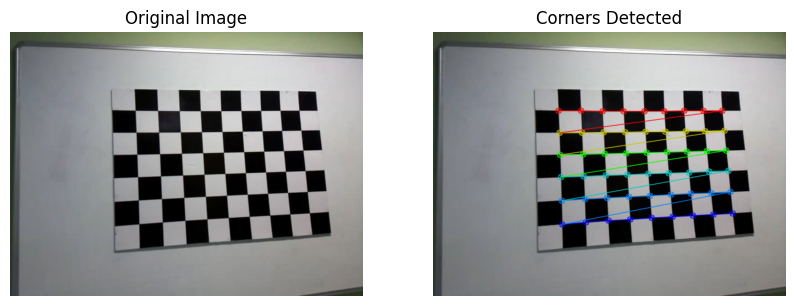

In [ ]:
image = cv2.imread('drive/MyDrive/chessboard.jpg')

# 이미지를 흑백으로 변환
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 체스보드 패턴의 내부 코너 개수 (행, 열)
pattern_size = (9, 6)

# 코너 찾기
retval, corners = cv2.findChessboardCorners(gray_image, pattern_size)

if retval:
    # 코너가 성공적으로 검출된 경우
    print("Corners found!")
    print("corners.shape=", corners.shape) #(9*6, 1, 2)

    # 부화소 수준 계산
    term_crit = (cv2.TERM_CRITERIA_MAX_ITER | cv2.TERM_CRITERIA_EPS, 10, 0.001)
    corners2 = cv2.cornerSubPix(gray_image, corners, (5, 5), (-1, -1), term_crit)

    # 코너 시각화
    dst = image.copy()
    cv2.drawChessboardCorners(dst, pattern_size, corners, retval)

    # 결과 이미지 표시
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(image, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title('Original Image')

    axs[1].imshow(dst, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title('Corners Detected')
    plt.show()
else:
    print("Corners not found.")

## cv2.findCirclesGrid()

### 함수 정의

  * retval, centers = cv2.findCirclesGrid(image, patternSize[, flags[, blobDetector]])

### 인수
  - image: 원형 격자(흑백) 이미지

  - patternSize: 원형 그리드 패턴의 내부 원의 개수를 나타내는 튜플.

  - flags (옵션): 원형 그리드 검출에 사용되는 플래그. 다양한 플래그를 조합하여 사용.
    * cv2.CALIB_CB_SYMMETRIC_GRID: 대칭 그리드 패턴을 사용합니다. (기본값)
    * cv2.CALIB_CB_ASYMMETRIC_GRID: 비대칭 그리드 패턴을 사용합니다.
    * cv2.CALIB_CB_CLUSTERING: 클러스터링 알고리즘을 사용하여 그리드 패턴을 검출합니다.
  
  - blobDetector (옵션): 사용자 정의 블롭 검출기를 사용하여 원을 검출. 일반적으로 cv2.SimpleBlobDetector_create() 함수를 사용하여 블롭 검출기를 생성.

### 반환값
  * retval: 그리드를 성공적으로 찾으면 True, 그렇지 않으면 False를 반환합니다.

  * centers: 발견된 원의 중심 좌표를 담고 있는 배열입니다.

### 함수 예제

Circles found!
centers.shape= (96, 1, 2)


<bound method Axes.set of <Axes: >>

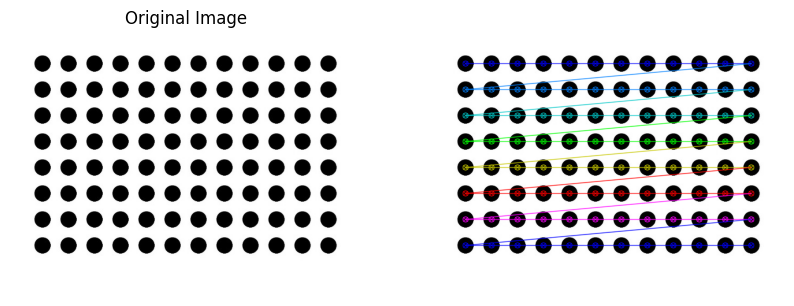

In [ ]:
# 이미지 불러오기
image = cv2.imread('/content/drive/MyDrive/Circle_Pattern.jpeg')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 패턴 검출
patternSize = (12, 8) # 열, 행
found, centers = cv2.findCirclesGrid(gray_image, patternSize)

if found:
    print("Circles found!")
    print("centers.shape=", centers.shape)

    # 결과 이미지 생성
    dst = image.copy()
    cv2.drawChessboardCorners(dst, patternSize, centers, found)
else:
    print("Circles not found.")

#결과 이미지 출력

fig, axs = plt.subplots(1,2, figsize=(10, 5))
axs[0].imshow(image, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Original Image')

axs[1].imshow(dst, cmap='gray')
axs[1].axis('off')
axs[1].set

# 3. 모멘트

## 영상 모멘트 설명

영상 모멘트는 화소의 가중평균으로 물체 인식을 위해 사용할 수 있는 디스크립터입니다. 영상을 분할하고 관심 물체로의 영상 모멘트를 계산하면, 물체의 면적, 무게중심, 물체의 기울어진 방향 등을 계산할 수 있습니다. 대표적인 모멘트는 중심 모멘트, Hu 모멘트가 있습니다.

### 1. 공간 모멘트 (Spatial Moments)

  공간 모멘트는 픽셀의 위치와 강도를 바탕으로 계산됩니다. $p$와 $q$는 모멘트의 차수이며, 공간 모멘트 $M_{pq}$는 다음과 같이 정의됩니다:

  $$
  M_{pq} = \sum_{x} \sum_{y} x^p y^q I(x, y)
  $$

  여기서 $I(x, y)$는 픽셀 위치 $(x, y)$에서의 픽셀 강도입니다.

  - 예를 들어, $M_{00}$은 이미지의 총 픽셀 강도의 합을 나타냅니다.
  - $M_{10}$은 픽셀의 x-좌표에 대한 가중합을 나타냅니다.
  - $M_{01}$은 픽셀의 y-좌표에 대한 가중합을 나타냅니다.

---

### 2. 중심 모멘트 (Central Moments)

  중심 모멘트는 이미지의 질량 중심을 기준으로 계산됩니다. 중심 모멘트 $\mu_{pq}$는 다음과 같이 정의됩니다:

  $$
  \mu_{pq} = \sum_{x} \sum_{y} (x - \bar{x})^p (y - \bar{y})^q I(x, y)
  $$

  여기서 $\bar{x}$와 $\bar{y}$는 이미지의 질량 중심 좌표로, 다음과 같이 계산됩니다:

  $$
  \bar{x} = \frac{M_{10}}{M_{00}}, \quad \bar{y} = \frac{M_{01}}{M_{00}}
  $$

  여기서 $M_{10}$, $M_{01}$, $M_{00}$는 각각의 공간 모멘트입니다.

---

### 3. 정규 중심 모멘트 (Normalized Central Moments)

  정규 중심 모멘트는 중심 모멘트를 이미지의 크기나 스케일에 독립적으로 만들어주는 모멘트입니다. 정규 중심 모멘트 $\eta_{pq}$는 다음과 같이 정의됩니다:

  $$
  \eta_{pq} = \frac{\mu_{pq}}{M_{00}^{1 + \frac{p + q}{2}}}
  $$

  정규 중심 모멘트는 객체의 크기, 회전, 위치에 대해 불변성을 제공하므로 다양한 변형에 대해 일관된 특성을 유지합니다.

  * $\mu_{pq}$는 중심 모멘트입니다.
  * $M_{00}$은 공간 모멘트로, 전체 이미지의 픽셀 강도의 합을 나타냅니다.
  * $p$와 $q$는 모멘트의 차수입니다.

---

### 4. Hu 모멘트

Hu 모멘트는 정규 중심 모멘트를 사용하여 계산됩니다. 다음은 Hu 모멘트의 정의입니다:

1. **첫 번째 Hu 모멘트**:
   $$
   \phi_1 = \eta_{20} + \eta_{02}
   $$

   이 모멘트는 모양의 형태를 단순히 합산하여 기본적인 형태의 크기를 나타냅니다.
   

2. **두 번째 Hu 모멘트**:
   $$
   \phi_2 = (\eta_{20} - \eta_{02})^2 + 4 \eta_{11}^2
   $$

   이 모멘트는 모양의 비대칭성 및 회전에 대한 정보를 제공합니다.


3. **세 번째 Hu 모멘트**:
   $$
   \phi_3 = (\eta_{30} - 3 \eta_{12})^2 + (3 \eta_{21} - \eta_{03})^2
   $$

   이 모멘트는 모양의 비틀림 및 왜곡을 설명합니다.


4. **네 번째 Hu 모멘트**:
   $$
   \phi_4 = (\eta_{30} + \eta_{12})^2 + (\eta_{21} + \eta_{03})^2
   $$

   이 모멘트는 모양의 회전과 관련된 정보를 제공합니다.


5. **다섯 번째 Hu 모멘트**:
   $$
   \phi_5 = (\eta_{30} - 3 \eta_{12})(\eta_{30} + \eta_{12}) \left[(\eta_{30} + \eta_{12})^2 - 3 (\eta_{21} + \eta_{03})^2\right] + (3 \eta_{21} - \eta_{03}) \left[3 (\eta_{30} + \eta_{12})^2 - (\eta_{21} + \eta_{03})^2\right]
   $$

   이 모멘트는 모양의 복잡한 기하학적 변형을 설명합니다.


6. **여섯 번째 Hu 모멘트**:
   $$
   \phi_6 = (\eta_{20} - \eta_{02}) \left[(\eta_{30} + \eta_{12})^2 - (\eta_{21} + \eta_{03})^2\right] + 4 \eta_{11} \left[\eta_{30} + \eta_{12} \left(3 \eta_{21} - \eta_{03}\right)\right]
   $$

   이 모멘트는 비대칭 및 기하학적 왜곡을 포함하는 정보를 제공합니다.


7. **일곱 번째 Hu 모멘트**:
   $$
   \phi_7 = (3 \eta_{21} - \eta_{03}) \left[(\eta_{30} - \eta_{12})^2 + 4 \eta_{11}^2\right] + (\eta_{30} + \eta_{12}) \left[(\eta_{21} - \eta_{03})^2 - 3 (\eta_{30} - \eta_{12})^2\right]
   $$

   이 모멘트는 회전, 크기, 형태의 복합적인 변형을 설명합니다.


이 Hu 모멘트들은 이미지의 형태를 불변적으로 표현하며, 회전, 크기, 위치 변화에 대해 강한 불변성을 유지합니다.


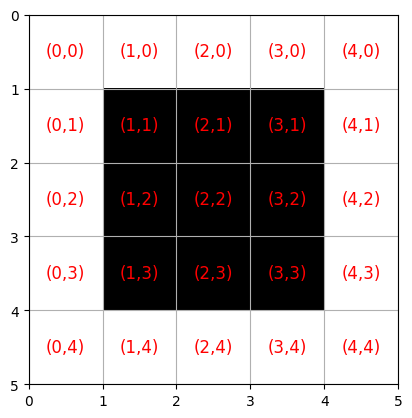

In [ ]:
#1 이진화 이미지 생성
image = create_square((5, 5),3)

plt.imshow(image, cmap='gray', extent=[0, 5, 5, 0])
plt.xticks([0, 1, 2, 3, 4, 5])
plt.yticks([0, 1, 2, 3, 4, 5])
plt.grid(True)

# 각 칸에 텍스트 추가
for i in range(5):
    for j in range(5):
        plt.text(i + 0.5, j + 0.5, f'({i},{j})', ha='center', va='center', fontsize=12, color='red')


plt.axis('on')
plt.show()

## cv2.moment()함수



In [ ]:
#2
#0이 아닌 값을 1로 정규화함. (ndarry / 최대값)
M = cv2.moments(image, True)

#모멘트는 i, j의 차수에 따라 결정되며 i + j <= 3, i >= 0, j >= 0 수식을 만족
#따라서 총 공간모멘트 개수는 4 + 3 + 2 + 1 = 10개 이다.
# 중심 모멘트는 기본적인 mu00 = m00, mu01 = 0, mu10 = 0 값을 제외한 7개이며 정규화 모멘트 또한 마찬가지이다. 총 24개의 key, value 쌍을 갖는다.

for key, value in M.items():
    print(f'{key}: {value}')

m00: 16.0
m10: 32.0
m01: 32.0
m20: 108.0
m11: 64.0
m02: 108.0
m30: 392.0
m21: 216.0
m12: 216.0
m03: 392.0
mu20: 44.0
mu11: 0.0
mu02: 44.0
mu30: 0.0
mu21: 0.0
mu12: 0.0
mu03: 0.0
nu20: 0.171875
nu11: 0.0
nu02: 0.171875
nu30: 0.0
nu21: 0.0
nu12: 0.0
nu03: 0.0


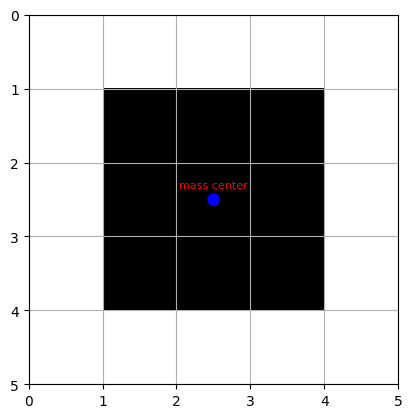

cx=2, cy=2


In [ ]:
#3 무게중심 구하기
cx = int(M['m10'] / M['m00'])
cy = int(M['m01'] / M['m00'])

# 이미지 복사
dst = image.copy()

# 이미지 표시
plt.imshow(dst, cmap='gray', extent=[0, 5, 5, 0])
plt.xticks([0, 1, 2, 3, 4, 5])
plt.yticks([0, 1, 2, 3, 4, 5])
plt.grid(True)

# 무게 중심 시각화 (파란색 원으로 표시)
plt.scatter(cx + 0.5, cy + 0.5, color='blue', s=100, edgecolor='black', zorder=5)

# 각 칸에 텍스트 추가
plt.text(cx + 0.5, cy + 0.3, "mass center", ha='center', va='center', fontsize=8, color='red')

plt.axis('on')
plt.show()

# 무게 중심 좌표 출력
print(f'cx={cx}, cy={cy}')

## `cv2.connectedComponentsWithStats()`, `cv2.findContours()` 함수

### `cv2.connetedComponentsWithStats()` 함수 정의

  - retval, `labels`, stats, `centroids` = cv2.connectedComponentsWithStats(binary_image)

#### 인수

  - `binary_image`: 입력 이진 이미지입니다. 픽셀 값이 0과 255인 2진 이미지여야 합니다.

  - `retval`: 연결된 구성 요소의 개수입니다.

  - `labels`: 각 픽셀에 대해 연결된 구성 요소의 레이블을 포함하는 행렬입니다. 같은 레이블을 가진 픽셀은 동일한 구성 요소에 속합니다.

  - `stats`: 각 구성 요소에 대한 통계 정보를 포함하는 행렬입니다. 각 행은 [x, y, width, height, area] 형태의 정보를 가지고 있습니다.

    * x, y: 바운딩 박스의 좌상단 꼭짓점의 좌표

    * width, height: 바운딩 박스의 너비와 높이

    * area: 구성 요소의 픽셀 개수

  - `centroids`: 각 구성 요소의 중심 좌표를 포함하는 행렬입니다.
  
---

### `cv2.findContours()` 함수 정의

- `contours`, hierarchy = cv2.findContours(binary_image, `mode`, `method`)

#### 인수
  - `binary_image`: 윤곽선을 찾을 이진 이미지입니다. 일반적으로 cv2.threshold 또는 cv2.Canny 함수를 사용하여 생성된 이미지입니다.

  - `mode`: 윤곽선을 찾는 방법을 지정하는 매개변수입니다.

    주요옵션
    * `cv2.RETR_EXTERNAL`: 가장 외곽의 윤곽선만 찾습니다.

    * cv2.RETR_LIST: 모든 윤곽선을 계층 구조 없이 찾습니다.

    *  cv2.RETR_CCOMP: 윤곽선을 2단계 계층 구조로 찾습니다. 외곽 윤곽선과 내부 윤곽선을 구분합니다.

    * cv2.RETR_TREE: 모든 윤곽선을 완전한 계층 구조로 찾습니다.

  - `method`: 윤곽선을 근사화하는 방법을 지정하는 매개변수입니다. 주요 옵션은 다음과 같습니다:

    주요옵션
    * cv2.CHAIN_APPROX_NONE: 윤곽선의 모든 점을 저장합니다.

    * `cv2.CHAIN_APPROX_SIMPLE`: 윤곽선의 꼭짓점만 저장합니다. 직선 부분의 점들을 모두 압축하여 메모리를 절약합니다.

    * cv2.CHAIN_APPROX_TC89_L1, cv2.CHAIN_APPROX_TC89_KCOS: Teh-Chin 체인 근사화 알고리즘을 사용합니다.


#### 반환값

  - `contours`: 윤곽선의 리스트입니다. 각 윤곽선은 점들의 배열로 표현됩니다.

  - `hierarchy`: 윤곽선의 계층 구조를 나타내는 배열입니다. 각 윤곽선의 부모-자식 관계를 포함합니다.

---

### `cv2.drawContours()` 함수 정의

  - cv2.drawContours(image, `contours`, contourIdx, color, thickness, lineType, hierarchy, maxLevel, offset)

#### 매개변수

  - `image`: 윤곽선을 그릴 대상 이미지. 이 이미지는 원본 이미지를 직접 수정합니다.

  - `contours`: 윤곽선의 리스트입니다. 각 윤곽선은 점의 리스트로 표현됩니다.
  일반적으로 cv2.findContours 함수로 얻어집니다. (N, 1, 2) 3차원 리스트입니다.

  - `contourIdx`: 그릴 윤곽선의 인덱스입니다. 모든 윤곽선을 그리려면 -1을 지정합니다.

  - `color`: 윤곽선의 색상입니다. <<여기까지 필수

  - `thickness`: 윤곽선의 두께입니다. 두께는 픽셀 단위로 지정됩니다.

  - `lineType`: 윤곽선의 선 유형입니다. 일반적으로 cv2.LINE_8, cv2.LINE_AA, 등으로 설정할 수 있습니다. cv2.LINE_8이 기본값입니다.

  - `hierarchy`: 윤곽선의 계층 정보입니다. cv2.findContours로 얻은 계층 정보를 사용합니다. 일반적으로 윤곽선 그리기에는 사용되지 않습니다. 타입 : ndarray

  - `maxLevel`: 그릴 윤곽선의 계층 수준입니다. 계층 정보가 있는 경우, 이 매개변수로 그릴 계층의 최대 수준을 지정합니다. 타입 : int

  - `offset`: 윤곽선의 위치를 이동시키는 오프셋입니다. 기본값은 (0, 0)입니다.

---

> 여러개의 객체가 존재하는 경우 `라벨링 혹은 경계선을 검출`하여 각 객체의 중심을 찾을 수 있다.

In [ ]:
#cv2.findContours 함수와 drawContours 함수

# 예제 이진 이미지 생성
binary_image = np.zeros((200, 200), dtype=np.uint8)
cv2.rectangle(binary_image, (50, 50), (150, 150), 255, -1)
cv2.circle(binary_image, (100, 100), 40, 0, -1)

# 윤곽선 찾기
contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# 윤곽선 정보 출력
print(f"Number of contours found: {len(contours)}")
for i, contour in enumerate(contours):
    print(f"Contour {i}:")
    for point in contour:
        print(f"  Point: {point[0]}")

# 윤곽선을 그리기 위해 원본 이미지 복사
contour_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

# 결과 시각화
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.title('Contours')
plt.axis('off')
plt.show()


Text(0.5, 1.0, 'Contours center')

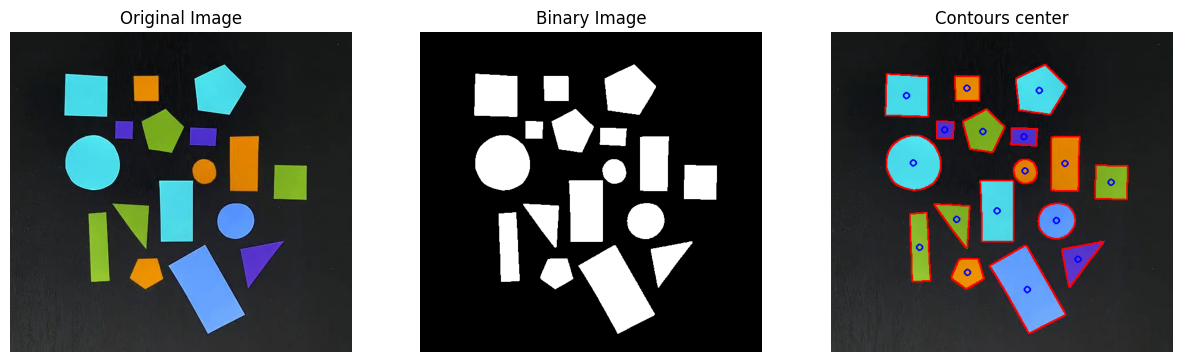

In [ ]:
#1 cv2.findContoures()함수 사용

#이미지 불러오기
image = cv2.imread('/content/drive/MyDrive/shapes_and_colors.webp')

#이진화
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
binary_image = cv2.threshold(gray_image, 70, 255, cv2.THRESH_BINARY)[1]

#배경 백색 노이즈 제거
binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=1)

#cv2.findContours() 윤곽선 검출
mode = cv2.RETR_EXTERNAL
method = cv2.CHAIN_APPROX_SIMPLE
contours, hierarchy = cv2.findContours(binary_image, mode, method)

dst = image.copy()
cv2.drawContours(dst, contours, -1, (255, 0, 0), 2)

#윤곽선마다 모먼트 검출
for contour in contours:
    M = cv2.moments(contour)
    cx = int(M['m10'] / M['m00'])
    cy = int(M['m01'] / M['m00'])

    # 무게 중심 시각화 (파란색 원으로 표시)
    cv2.circle(dst, (cx, cy), 5, (0, 0, 255), 2)

fig, axs = plt.subplots(1, 3, figsize=(15, 10))

axs[0].imshow(image, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Original Image')

axs[1].imshow(binary_image, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Binary Image')

axs[2].imshow(dst, cmap='gray')
axs[2].axis('off')
axs[2].set_title('Contours center')


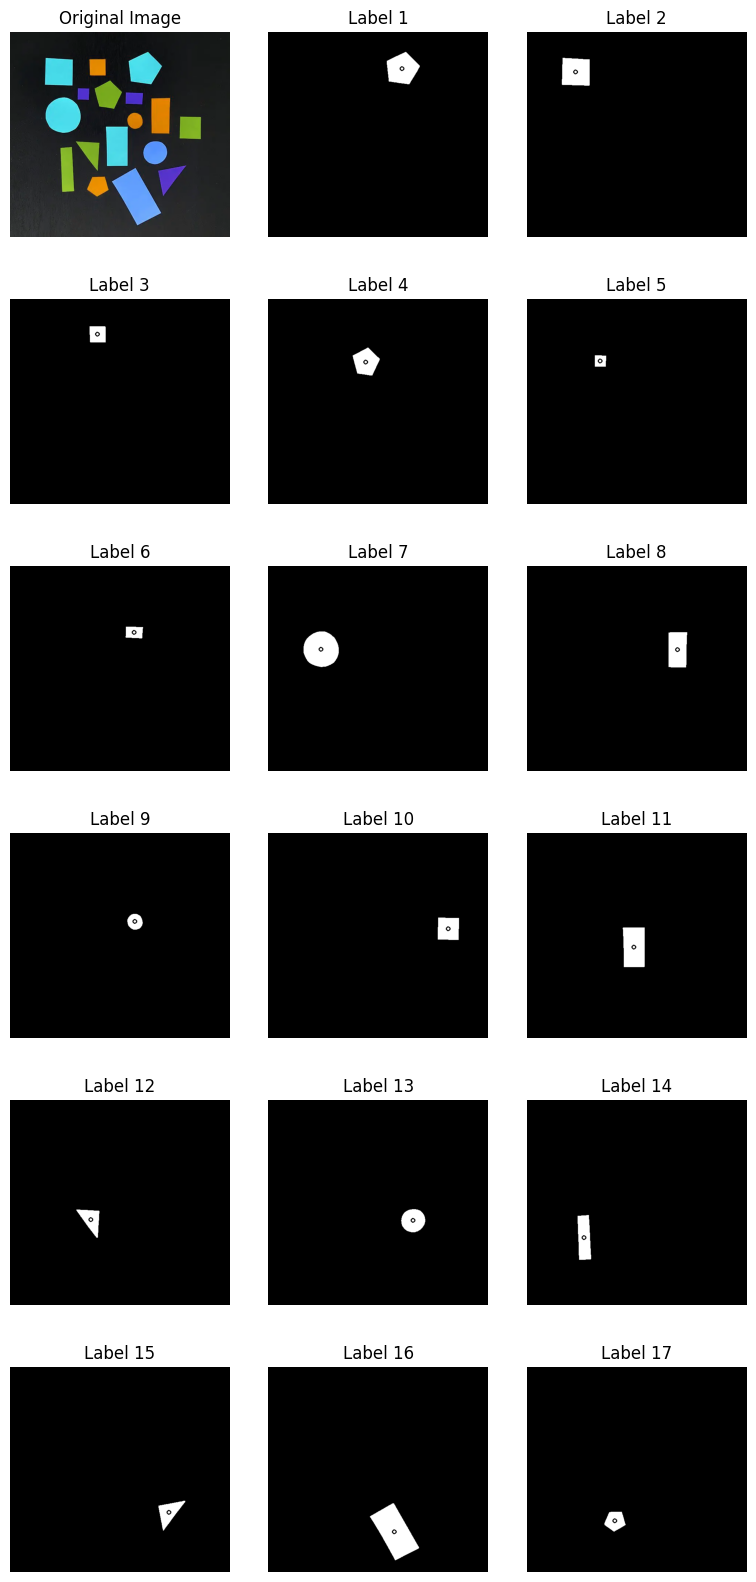

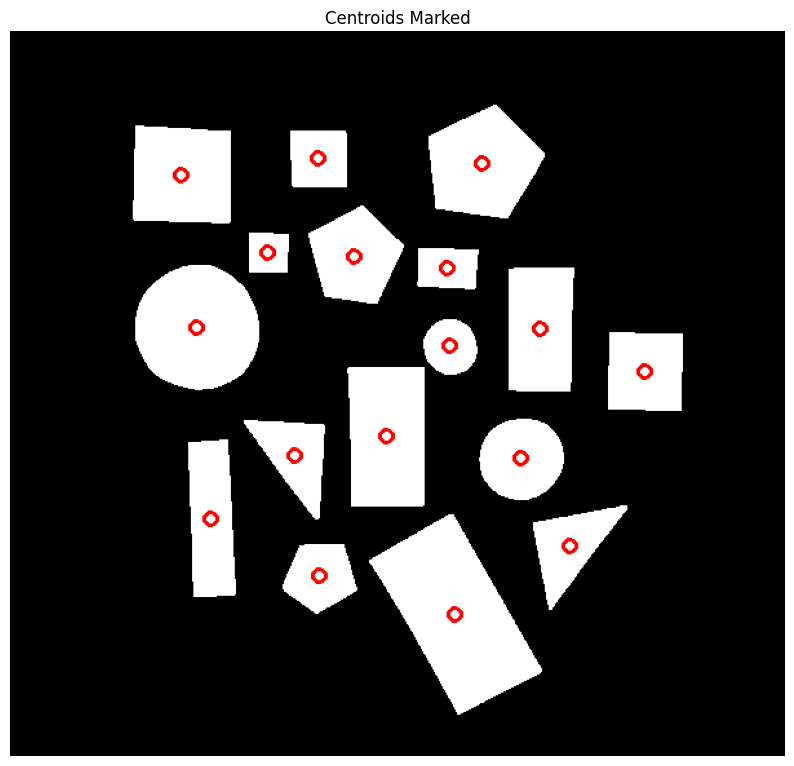

In [ ]:
# 연결된 구성 요소 찾기
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image)

# 원본 이미지 복사
dst2 = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)  # 흑백 이미지를 컬러 이미지로 변환

# 서브플롯 생성
fig, axs = plt.subplots(ret // 3, 3, figsize=(10, 20))

# 각 구성 요소의 무게 중심 계산 및 표시
for label in range(1, ret):  # 레이블 0은 배경이므로 제외
    # 구성 요소의 이진 마스크 생성
    component_mask = (labels == label).astype(np.uint8) * 255  # 255로 곱하여 흰색으로 표시

    # 구성 요소의 모멘트 계산
    M = cv2.moments(component_mask, True)
    if M['m00'] != 0:  # 분모가 0이 아닌 경우에만 계산
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])

        # 무게 중심에 원 그리기
        cv2.circle(dst2, (cx, cy), 5, (0, 0, 255), 2)  # 빨간색 원

         # 무게 중심에 원 그리기
        cv2.circle(component_mask, (cx, cy), 5, (0, 0, 255), 2)  # 빨간색 원

    # 구성 요소의 마스크를 서브플롯에 표시
    row, col = label // 3, label % 3

    axs[0, 0].imshow(image, cmap='gray')
    axs[0, 0].axis('off')
    axs[0, 0].set_title('Original Image')

    if component_mask is None:
        axs[row, col].axis('off')
    else:
        axs[row, col].imshow(component_mask, cmap='gray')
        axs[row, col].set_title(f'Label {label}')
        axs[row, col].axis('off')

# 서브플롯 간의 간격 조정
plt.subplots_adjust(hspace=0.3, wspace=0)  # 수직(hspace) 및 수평(wspace) 간격을 조정

plt.show()

# 결과 이미지 표시
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(dst2, cv2.COLOR_BGR2RGB))
plt.title('Centroids Marked')
plt.axis('off')
plt.show()

## Hu 모멘트 예제

- Hu 모멘트가 회전, 크기 변화와 평행이동에 상관없이 일정함을 확인하기 위해 객체를 변형시키기 전과 후의 Hu 모멘트를 비교해볼 것입니다.

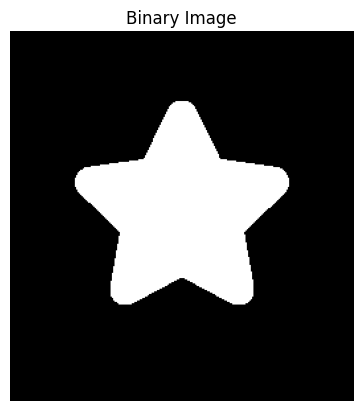

In [ ]:
#1 이미지 불러오기

image = cv2.imread('/content/drive/MyDrive/star.webp')

binary_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
binary_image = cv2.bitwise_not(binary_image)
binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=2)
binary_image = cv2.threshold(binary_image, 70, 255, cv2.THRESH_BINARY)[1]

plt.imshow(binary_image, cmap='gray')
plt.title('Binary Image')
plt.axis('off')
plt.show()

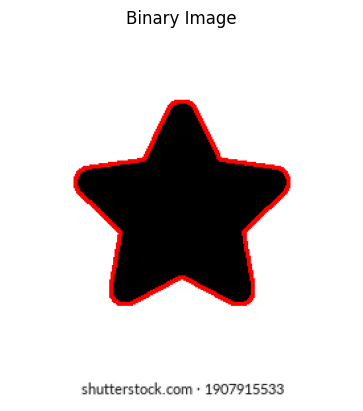

[[ 1.79867855e-01]
 [ 1.28819060e-07]
 [ 4.91942884e-08]
 [ 8.83677859e-10]
 [ 1.71855973e-18]
 [-3.84642201e-15]
 [-5.56715165e-18]]


In [ ]:
#2 경계선 검출, hu 모멘트 계산

mode = cv2.RETR_EXTERNAL
method = cv2.CHAIN_APPROX_SIMPLE
contours = cv2.findContours(binary_image, mode, method)[0]

dst = image.copy()

#경계선 1개 밖에 없긴 한데,, 경계선에 찍힌 N개의 점 출력(N, 1, 2)
cnt = contours[0]
cv2.drawContours(dst, [cnt], -1, (255, 0, 0), 2)

#변환시키기 전 hu 모멘트 계산
M = cv2.moments(cnt)  #정규화 모멘트로 Hu 모멘트를 계산한다.
hu_moments = cv2.HuMoments(M)
print(hu_moments) # 7개의 모멘트 출력 ( )

plt.imshow(dst, cmap='gray')
plt.title('Binary Image')
plt.axis('off')
plt.show()

A= [[ 1.41421356e-01  1.41421356e-01  1.11958199e+02]
 [-1.41421356e-01  1.41421356e-01  1.65429282e+02]]


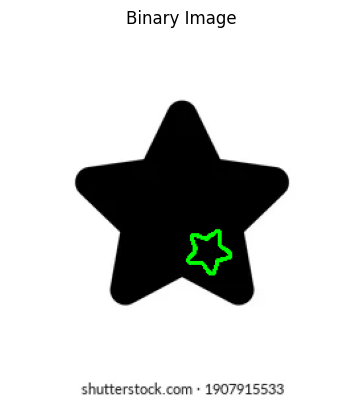

[[ 1.80866517e-01]
 [ 1.25645690e-05]
 [ 6.30389312e-08]
 [ 8.83400680e-08]
 [-5.85386651e-15]
 [ 2.21906587e-10]
 [ 3.03174488e-15]]


In [ ]:
#3 회전 변환 행렬을 이용하여 크기, 각도 조절(회전 중심을 무게중심으로 함)

angle = 45.0
scale = 0.2

cx = M['m10'] / M['m00']
cy = M['m01'] / M['m00']

center = ( cx, cy )
t = (20, 30)

# 회전 변환 행렬 계산
A = cv2.getRotationMatrix2D(center, angle, scale)

# 평행이동
A[:, 2] += t
print(f'A= {A}')

dst2 = image.copy()

cnt2 = cv2.transform(cnt, A)
cv2.drawContours(dst2, [cnt2], -1, (0, 255, 0), 2)

plt.imshow(dst2, cmap='gray')
plt.title('Binary Image')
plt.axis('off')
plt.show()

# 변환시킨 후 Hu모멘트 계산
M2 = cv2.moments(cnt2)
hu_moments2 = cv2.HuMoments(M2)
print(hu_moments2)

In [ ]:
#4 변환 전과 후의 Hu 모멘트 비교

diffSum = np.sum(cv2.absdiff(hu_moments, hu_moments2))
print(f'diffSum = {diffSum}')

#diffSum = 0.00101.... 매우 적은 값을 가지므로 Hu 모멘트가 어파인 변환에 불변인 것을 의미한다. 0이 아니므로 불변이 아니라고 볼 수 있지만 이는 해상도 때문에 0이 아닌 값을 갖는 것이다.

diffSum = 0.0010111990123841189


# 4. 모양 관련 특징 검출



## 모양 특징 검출 관련 함수


### 1. 컨투어의 길이 및 면적 계산

  - cv2.arcLength(contour, closed):

    * 용도: 주어진 `컨투어의 둘레(주변 길이)`를 계산하여 반환.

    * 설명: contour는 컨투어 포인트들의 배열이고, closed는 컨투어가 닫혀 있는지 여부를 나타내는 불리언 값입니다. True이면 닫힌 컨투어, False이면 열린 컨투어로 간주합니다.

  - cv2.contourArea(cnt):

    * 용도: 주어진 컨투어의 면적을 계산하여 반환.

    * 설명: cnt는 컨투어 포인트들의 배열입니다. 이 함수는 `컨투어가 감싸고 있는 영역의 면적`을 반환합니다.




### 2. 컨투어를 포함하는 경계 상자 계산

  - cv2.boundingRect(cnt):

    * 용도: 주어진 컨투어를 포함하는 `수평-수직 직사각형 경계 상자`를 계산합니다.

    * 설명: cnt는 컨투어 포인트들의 배열입니다. 이 함수는 `직사각형 좌측 상단 (x, y) 좌표와 width 및 height 값을 반환`하여 컨투어를 포함하는 직사각형을 정의합니다.




### 3. 최소 영역의 회전된 직사각형 계산

  - cv2.minAreaRect(cnt):

    * 용도: 주어진 컨투어를 포함하는 최소 면적의 회전된 직사각형을 계산합니다.

    * 설명: cnt는 컨투어 포인트들의 배열입니다. 이 함수는 `직사각형의 중심 좌표 (x, y), 크기 (width, height)`, 그리고 회전 각도를 반환합니다.

  - cv2.boxPoints(rect):

    * 용도: cv2.minAreaRect로부터 얻은 회전된 직사각형의 네 개의 꼭짓점  좌표를 계산합니다. (어파인 변환)

    * 설명: rect는 cv2.minAreaRect 함수의 결과물입니다. 이 함수는 회전된 직사각형의 네 개의 꼭짓점 좌표를 반환합니다.

### 4. 최소 영역의 원 계산

  - cv2.minEnclosingCircle(cnt):

    * 용도: 주어진 컨투어를 포함하는 최소 면적의 원을 계산합니다.

    * 설명: cnt는 컨투어 포인트들의 배열입니다. 이 함수는 원의 중심 좌표 (x, y)와 반지름 radius를 반환합니다.

maxLength= 1369.6509273052216


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
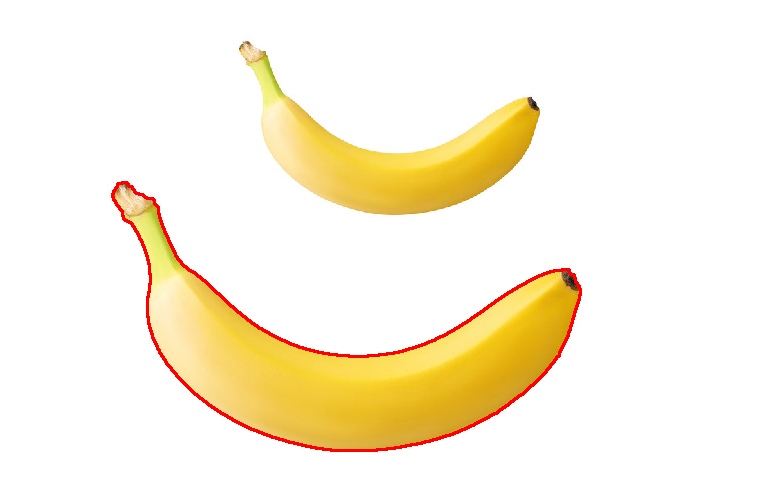

In [5]:
#1 이미지에서 컨투어 결정하기

# 이미지 읽기
image = cv2.cvtColor(cv2.imread('/content/drive/MyDrive/banana.PNG'), cv2.COLOR_BGR2RGB)

# 그레이스케일 변환 및 비트 반전
gray = np.bitwise_not(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))

# 이진화
_, binary = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

kernel = np.ones((3, 3), np.uint8)

#흰색 객체 내부 검은색 노이즈 제거
binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=1)

#검은색 배경 내부 흰색 노이즈 제거
binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)

mode = cv2.RETR_EXTERNAL
method = cv2.CHAIN_APPROX_SIMPLE
contours = cv2.findContours(binary, mode, method)[0]

# 컨투어 그리기
dst = image.copy()
cv2.drawContours(dst, contours, -1, (255, 0, 0), 2)

maxLength = 0
k = 0

# 가장 긴 컨투어 찾기 cv2.arcLength()
for i, contour in enumerate(contours):
    perimeter = cv2.arcLength(contour, closed = True)
    if perimeter > maxLength:
        maxLength = perimeter
        k = i
print('maxLength=', maxLength)

cnt = contours[k]
dst2 = image.copy()
cv2.drawContours(dst2, [cnt], -1, (255, 0, 0), 2)

area= 45656.0
x= 112 y= 182 width= 469 height= 269
rect= ((327.9322509765625, 336.000244140625), (478.4986877441406, 224.39981079101562), 11.11081600189209)
box= [[ 71 399]
 [114 179]
 [584 272]
 [541 492]]


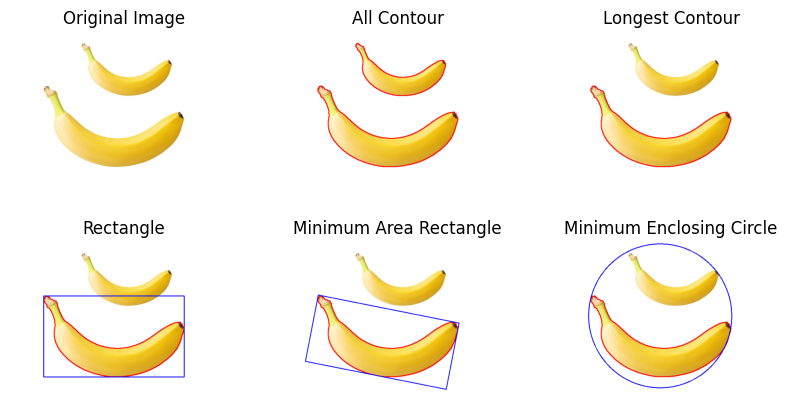

In [6]:
#사각형 둘러싸기 cv2.contourArea(), cv2.boundingRect()
area = cv2.contourArea(cnt)
print('area=', area)
x, y, width, height = cv2.boundingRect(cnt)
dst3 = dst2.copy()
cv2.rectangle(dst3, (x, y), (x + width, y + height), (0, 0, 255), 2)
print('x=', x, 'y=', y, 'width=', width, 'height=', height)

# 최소 면적 사각형 cv2.minAreaRect()
rect = cv2.minAreaRect(cnt)
print('rect=', rect)

box = cv2.boxPoints(rect)
box = box.astype(np.int32)

print('box=', box)
dst4 = dst2.copy()

#기울어진 사각형이므로
cv2.drawContours(dst4, [box], 0, (0, 0, 255), 2)

# 외접원 cv2.minEnclosingCircle()
(x, y), radius = cv2.minEnclosingCircle(cnt)
dst5 = dst2.copy()
center = (int(x), int(y))
radius = int(radius)
cv2.circle(dst5, center, radius, (0, 0, 255), 2)


fig, axs = plt.subplots(2, 3, figsize=(10, 5))

axs[0, 0].imshow(image, cmap='gray')
axs[0, 0].axis('off')
axs[0, 0].set_title('Original Image')

axs[0, 1].imshow(dst, cmap='gray')
axs[0, 1].axis('off')
axs[0, 1].set_title('All Contour')

axs[0, 2].imshow(dst2, cmap='gray')
axs[0, 2].axis('off')
axs[0, 2].set_title('Longest Contour')

axs[1, 0].imshow(dst3, cmap='gray')
axs[1, 0].axis('off')
axs[1, 0].set_title('Rectangle')

axs[1, 1].imshow(dst4, cmap='gray')
axs[1, 1].axis('off')
axs[1, 1].set_title('Minimum Area Rectangle')

axs[1, 2].imshow(dst5, cmap='gray')
axs[1, 2].axis('off')
axs[1, 2].set_title('Minimum Enclosing Circle')

plt.show()

## 컨투어 근사화







### 1. `직선 근사`

**point의 좌표(contour 좌표)를 `최소 자승법`으로 직선 근사시켜 반환하는 함수.**

  * cv2.fitLine(points, distType, param, reps, aeps[, line])

#### 인수

  * points (필수): numpy 배열로 표현된 좌표점들의 집합. shape = (n개 , 차원) 데이터 타입은 float32 또는 float64.

  * distType (필수): 거리 유형을 지정합니다.

    거리유형
    - cv2.DIST_L2: L2 norm (Euclidean distance, 유클리드 거리)
    - cv2.DIST_L1: L1 norm (Manhattan distance, 맨해튼 거리)
    - cv2.DIST_L12: L12 norm
    - cv2.DIST_FAIR: Fair distance
    - cv2.DIST_WELSCH: Welsch distance
    - cv2.DIST_HUBER: Huber distance

  * param (필수): 특정 거리 유형의 매개변수입니다. 대부분의 경우 0을 사용할 수 있습니다.

  * reps (필수):반복의 정확도 (accuracy of the iterations)입니다. 반복 과정이 reps 값보다 작은 변화율을 가질 때 중지됩니다.

  * aeps (필수): 각 점의 정확도 (accuracy of the points)입니다. 각 점이 aeps 값보다 작은 변화율을 가질 때 중지됩니다.

  * line (옵션): 피팅된 직선을 저장할 배열입니다. 함수 호출 시 반환됩니다.배열 형태는 (4,) 또는 (6,)입니다. 2D의 경우 $(v_x, v_y, x_0, y_0$) 형태로 반환됩니다.

#### 반환값
  * line: 주어진 포인트 집합에 대해 피팅된 직선을 나타내는 배열입니다.

---

#### 1.2.  `최소 자승법(Least Squares Method)`이란?

##### 1. 개념

  - 최소 자승법은 주어진 데이터에 가장 잘 맞는 함수 또는 모델을 찾기 위한 수학적 기법입니다.
  - 이 기법은 주로 회귀 분석에서 사용되며, 데이터 포인트와 모델의 예측 값 간의 오차의 제곱합을 최소화하는 방법입니다.

    * 오차$(e_i$): 각 데이터 포인트 $((x_i, y_i)$)에 대해 모델의 예측값과 실제 데이터 값 간의 차이입니다.

    * 자승$(S$): 오차를 제곱하여 부호의 영향을 없애고, 오차의 크기에 비례하는 방식으로 합산합니다.

##### 2. 수학적 표현

  * 주어진 데이터 포인트 $((x_i, y_i)$)가 $(n$)개 있을 때, 모델 함수 $(f(x)$)가 예측한 값이 $(f(x_i)$)입니다. 이때, 오차 $(e_i$)는 다음과 같이 표현됩니다:

  $$
  e_i = y_i - f(x_i)
  $$

  * 최소 자승법은 $(S$)는 오차$(e_i$)의 제곱합을 최소화하는 모델 $(f(x)$)를 찾습니다.

  $$
  S = \sum_{i=1}^{n} (y_i - f(x_i))^2
  $$

##### 3. 예시: 1차 선형회귀

  * 가장 간단한 경우는 1차 선형 회귀입니다. 이 경우 모델은 다음과 같습니다:

  $$
  f(x) = \beta_0 + \beta_1 x
  $$

  * 여기서 $(\beta_0$)는 절편, $(\beta_1$)은 기울기입니다. 최소 자승법을 사용하여 $(\beta_0$)와 $(\beta_1$)을 찾습니다.

  * 오차 제곱합 $S$:

  $$
  S = \sum_{i=1}^{n} (y_i - (\beta_0 + \beta_1 x_i))^2
  $$

  * 이때 $(S$)를 최소화하는 $(\beta_0$)와 $(\beta_1$)을 찾습니다.

---

#### 1.3.  방향벡터와 직선 위 임의의 점 좌표으로 이미지에 직선 그리는 방법

- cv2.fitLine 함수에서 반환된 파라미터:

  * $v_x$: 직선 방향 벡터의 x 성분

  * $v_y$: 직선 방향 벡터의 y 성분

  * $x_0$: 직선 위의 한 점의 x 좌표

  * $y_0$: 직선 위의 한 점의 y 좌표

- 직선의 기울기 $m$는 다음과 같이 계산됩니다:

  $$
  m = \frac{v_y}{v_x}
  $$

- 직선 방정식은 다음과 같습니다:

  $$
  y - y_0 = \frac{v_y}{v_x}(x - x_0)
  $$
- 이미지의 왼쪽 경계 ($x = 0$)에서의 y 좌표:

  $$
  y_1 = \left( -\frac{x_0 \cdot vy}{vx} \right) + y_0
  $$

- 이미지의 상단 경계 ($y = 0$)에서의 x 좌표:

  $$
  x_1 = \left( -\frac{y_0 \cdot vx}{vy} \right) + x_0
  $$

- 이미지의 왼쪽, 오른쪽과 상, 하단 경계 중 두 경계를 지나므로 모두 계산하여 최대값 $(0 \leq x \leq cols - 1, 0 \leq y \leq rows - 1$)인 경우에만 값을 출력하도록 해야합니다.

- 이미지의 경계와 만나는 지점을 찾은 후 cv2.line()함수로 그리면 됩니다.

---


최적의 기울기 (a): 0.7499999995497489
최적의 절편 (b): 1.3900000016509204


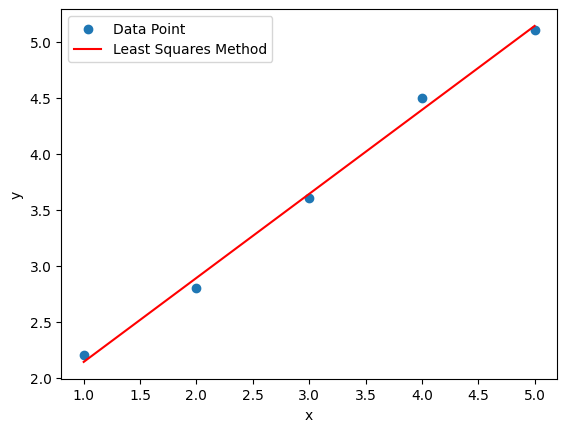

In [7]:
#최소 자승법 회귀 설명

from scipy.optimize import curve_fit

# 예제 데이터
x = np.array([1, 2, 3, 4, 5])
y = np.array([2.2, 2.8, 3.6, 4.5, 5.1])

# 모델 정의
def linear_model(x, a, b):
    return a * x + b

# 최적의 파라미터 찾기
params, covariance = curve_fit(linear_model, x, y)

a, b = params

# 예측 값
y_pred = linear_model(x, a, b)

# 결과 출력
print(f"최적의 기울기 (a): {a}")
print(f"최적의 절편 (b): {b}")

# 데이터 및 회귀선 시각화
plt.scatter(x, y, label='Data Point')
plt.plot(x, y_pred, color='red', label='Least Squares Method')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


<ipython-input-8-1e774eefef56>:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y1 = int((-x * vy / vx) + y)
<ipython-input-8-1e774eefef56>:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y2 = int(((cols - x - 1 ) * vy / vx) + y)


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
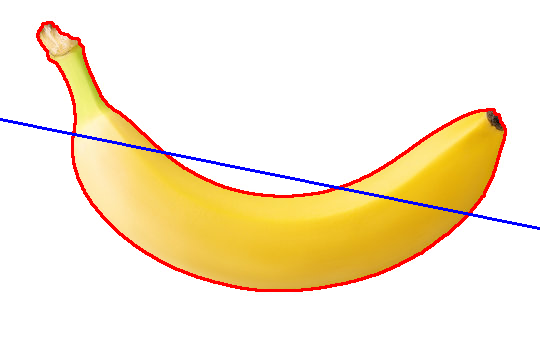

In [8]:
#1
# 이미지 읽기
image = cv2.cvtColor(cv2.imread('/content/drive/MyDrive/banana.jpg'), cv2.COLOR_BGR2RGB)

# 그레이스케일 변환 및 비트 반전
gray = np.bitwise_not(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))

# 이진화
_, binary = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

kernel = np.ones((3, 3), np.uint8)

#흰색 객체 내부 검은색 노이즈 제거
binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=1)

#검은색 배경 내부 흰색 노이즈 제거
binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)


# 컨투어 그리기
mode = cv2.RETR_EXTERNAL
method = cv2.CHAIN_APPROX_SIMPLE
contours = cv2.findContours(binary, mode, method)[0] #contours는 4차원이다.
#[(컨투어 개수)1 * (지점 개수) 610 * (좌표) 1 * 2]

dst = image.copy()
cnt = contours[0]
cv2.drawContours(dst, [cnt], -1, (255, 0, 0), 2)


#2
dst2 = dst.copy()
rows, cols = dst2.shape[:2] #dst2는 3차원 이니깐,,
[vx, vy, x ,y] = cv2.fitLine(cnt, cv2.DIST_L2, 0, 0.01, 0.01)
y1 = int((-x * vy / vx) + y)
y2 = int(((cols - x - 1 ) * vy / vx) + y)
cv2.line(dst2, (cols - 1, y2), (0, y1), (0, 0, 255), 2)


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
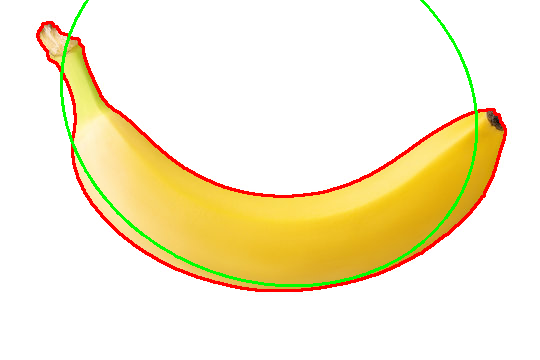

In [9]:
#3
ellipse = cv2.fitEllipse(cnt)
dst3 = dst.copy()
cv2.ellipse(dst3, ellipse, (0, 255, 0), 2)


### 1. 컨투어 형태 단순화

**컨투어의 형태를 단순화하는 함수:**

- **`cv2.approxPolyDP(contour, epsilon, closed)`**:
  - **용도**: 주어진 컨투어를 단순화하여 새로운 근사 폴리곤(다각형)을 생성합니다.
  - **설명**:
    - `contour`: 단순화할 컨투어 포인트들의 배열입니다.
    - `epsilon`: 원본 컨투어와 근사 폴리곤 사이의 최대 거리입니다. 이 값이 작을수록 폴리곤이 더 정밀하게 원본 컨투어를 근사화합니다.
    - `closed`: 컨투어가 닫혀 있는지 여부를 나타내는 불리언 값입니다. `True`이면 닫힌 컨투어, `False`이면 열린 컨투어로 간주합니다.

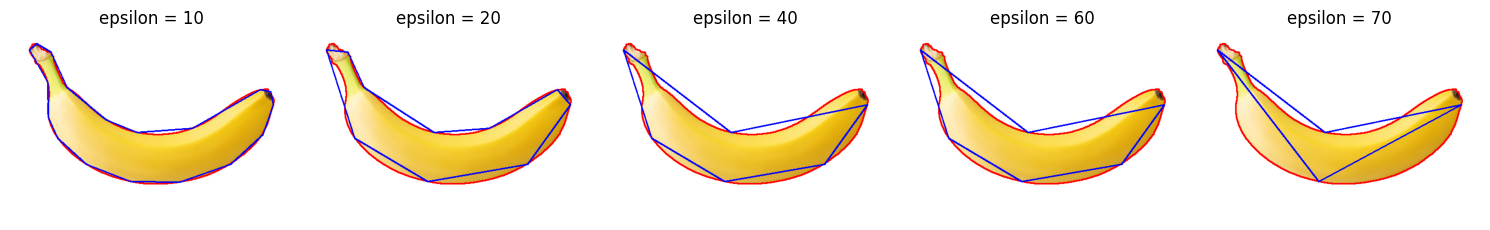

In [10]:
def VisualPoly(cnt, dst, epsilons):

    num_epsilons = len(epsilons)

    # subplot 설정
    fig, axs = plt.subplots(1, num_epsilons, figsize=(15, 5))

    for i, epsilon in enumerate(epsilons):
        # epsilon 값에 대해 다각형 근사화
        poly = cv2.approxPolyDP(cnt, epsilon, closed=True)

        # 원본 이미지 복사본 만들기
        dst_copy = dst.copy()

        # 근사화된 다각형 그리기
        cv2.drawContours(dst_copy, [poly], -1, (0, 0, 255), 2)

        # subplot에 결과 이미지 표시
        axs[i].imshow(dst_copy)
        axs[i].set_title(f'epsilon = {epsilon}')
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


# epsilon 값 리스트
epsilons = [10, 20, 40, 60, 70]

# VisualPoly 함수 호출
VisualPoly(cnt, dst, epsilons)


### 2. 폴리곤 내부/외부 점 테스트

**점이 폴리곤 내부에 있는지 여부를 테스트하는 함수:**

- **`cv2.pointPolygonTest(contour, point, measureDist)`**:
  - **용도**: 주어진 점이 컨투어 내부에 있는지, 외부에 있는지, 또는 컨투어 위에 있는지를 테스트합니다.
  - **설명**:
    - `contour`: 테스트할 컨투어 포인트들의 배열입니다.
    - `point`: 테스트할 점의 좌표입니다.
    - `measureDist`: 점과 컨투어 사이의 거리를 계산할지 여부를 나타내는 불리언 값입니다. `True`이면 거리도 계산합니다.
  - **반환 값**:
    - 점이 컨투어 내부에 있으면 양수, 컨투어 위에 있으면 0, 컨투어 외부에 있으면 음수를 반환합니다. `measureDist`가 `True`인 경우, 반환 값은 점과 컨투어 사이의 거리가 됩니다.

dist_maximum_inside = 47.095647357266465
dist_maximum_outside = 193.19679086361657


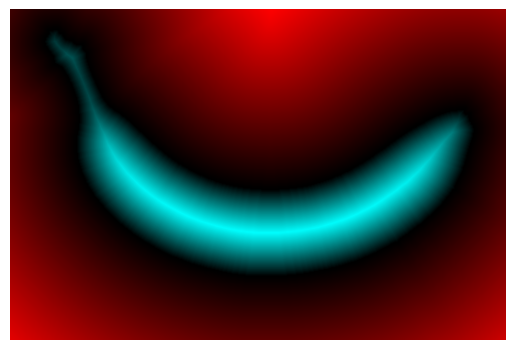

In [11]:
dst5 = dst.copy()

# 최대 거리 초기화
dist_maximum_inside = 0
dist_maximum_outside = 0

# 최대 거리 계산 (내부와 외부 구분)
for y in range(rows):
    for x in range(cols):
        dist = cv2.pointPolygonTest(cnt, (x, y), True)
        if dist > dist_maximum_inside:
            dist_maximum_inside = dist
        elif dist < dist_maximum_outside:
            dist_maximum_outside = dist

# 최대 거리 절댓값 변환
dist_maximum_outside = abs(dist_maximum_outside)

print('dist_maximum_inside =', dist_maximum_inside)
print('dist_maximum_outside =', dist_maximum_outside)

# 거리 정규화 및 색상 매핑
for y in range(rows):
    for x in range(cols):
        dist = cv2.pointPolygonTest(cnt, (x, y), True)
        if dist > 0:
            dist_normalized = int((dist / dist_maximum_inside) * 255)
            dst5[y, x] = (dist_normalized, dist_normalized, 0)  # 내부
        elif dist < 0:
            dist_normalized = int((abs(dist) / dist_maximum_outside) * 255)
            dst5[y, x] = (0, 0, dist_normalized)  # 외부
        else:
            dst5[y, x] = (0, 0, 0)  # 배경

# 결과 이미지 시각화
plt.imshow(cv2.cvtColor(dst5, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


### 3. 볼록 껍질 계산

**컨투어의 볼록 껍질을 계산하는 함수:**

- **`cv2.convexHull(points, hull, clockwise, returnPoints)`**:
  - **용도**: 주어진 포인트 집합의 볼록 껍질을 계산합니다.
  - **설명**:
    - `points`: 입력 포인트들의 배열입니다.
    - `hull`: 결과로 나올 볼록 껍질을 저장할 배열입니다. 생략할 수 있습니다.
    - `clockwise`: 볼록 껍질 포인트들의 정렬 방향을 나타내는 불리언 값입니다. `True`이면 시계 방향, `False`이면 반시계 방향입니다.
    - `returnPoints`: 볼록 껍질의 포인트를 반환할지 인덱스를 반환할지 여부를 나타내는 불리언 값입니다. `True`이면 포인트를, `False`이면 인덱스를 반환합니다.
  - **반환 값**: 볼록 껍질 포인트들의 배열입니다.

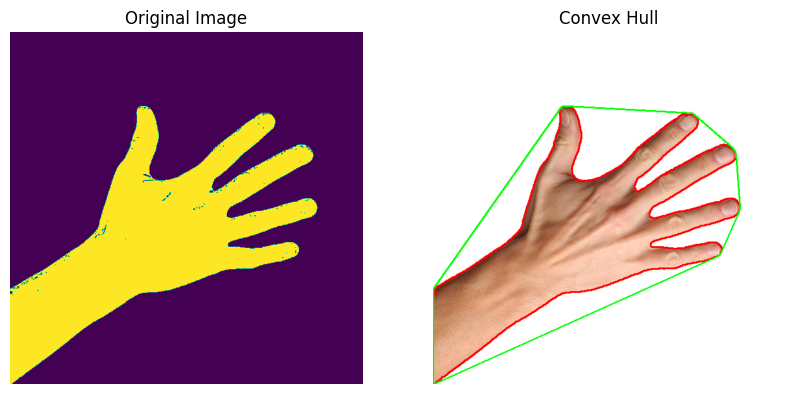

In [15]:
#이미지 불러오기
image = cv2.imread('/content/drive/MyDrive/Image/Hand.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#HSV 색상공간으로 변환하여 이진 이미지 생성/
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
lowerb = (0, 40, 0)
upperb = (20, 180, 255)
bImage = cv2.inRange(hsv, lowerb, upperb)

mode = cv2.RETR_EXTERNAL
method = cv2.CHAIN_APPROX_SIMPLE
contours = cv2.findContours(bImage, mode, method)[0]

dst = image.copy()
cnt = contours[0]
cv2.drawContours(dst, [cnt], -1, (255, 0, 0), 2)

#cv2.convexHull() 함수
dst2 = dst.copy()
rows, cols = dst2.shape[:2]
hull = cv2.convexHull(cnt)
cv2.drawContours(dst2, [hull], -1, (0, 255, 0), 2)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(bImage)
axs[0].axis('off')
axs[0].set_title('Original Image')

axs[1].imshow(dst2)
axs[1].axis('off')
axs[1].set_title('Convex Hull')

plt.show()


### 4. 볼록 결함 계산

**볼록 껍질과 컨투어 사이의 볼록 결함을 계산하는 함수:**

- **`cv2.convexityDefects(contour, convexhull)`**:
  - **용도**: 주어진 컨투어와 볼록 껍질 사이의 볼록 결함(함몰된 부분)을 계산합니다.
  - **설명**:
    - `contour`: 컨투어 포인트들의 배열입니다.
    - `convexhull`: `cv2.convexHull` 함수로 계산된 볼록 껍질의 인덱스 배열입니다.
  - **반환 값**: 결함을 나타내는 배열로, 각 결함은 시작 포인트, 끝 포인트, 가장 먼 포인트, 그리고 결함 거리로 구성됩니다.


612, 612
defect.shape= (16, 1, 4)
114
16497
1280
13418
142
229
30256
162
186
40407
162
114
154
42498
458
32741


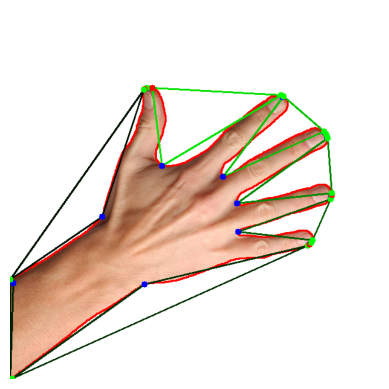

In [38]:
dst3 = dst.copy()
rows, cols = dst3.shape[:2]

#Contours의 인덱스를 반환함.
hull = cv2.convexHull(cnt, returnPoints=False)
#hull.shape = (n, 1)

hull = hull[:, 0]
#hull.shape = (n, )

#고급 인덱싱(정수 배열) 사용
hull_points = cnt[hull]
cv2.drawContours(dst3, [hull_points], -1, (0, 255, 0), 2)

print(f'{rows}, {cols}')

#3 cv2.convexityDefects()로 볼록결함 defects를 계산
T = 50
defects = cv2.convexityDefects(cnt, hull)
print('defect.shape=', defects.shape)
#defect.shape = (n, 1, 4)

for i in range(defects.shape[0]):
    s, e, f, d = defects[i, 0] #depth 반환 (좌표는 포인터의 인덱스 반환)
    dist = d
    start = tuple(cnt[s][0])
    end = tuple(cnt[e][0])
    far = tuple(cnt[f][0])

    print(dist)

    cv2.line(dst3, start, end, [0, 15*i, 0], 2)
    cv2.line(dst3, start, far, [0, 15*i, 0], 2)
    cv2.line(dst3, end, far, [0, 15*i, 0], 2)

    cv2.circle(dst3, far, 5, [0, 0, 255], -1)
    cv2.circle(dst3, start, 5, [0, 255, 0], -1)
    cv2.circle(dst3, end, 5, [255, 0, 0], -1)

    # if dist > T:
    #     cv2.line(dst3, start, end, [0, 15*i, 0], 2)
    #     cv2.line(dst3, start, far, [0, 15*i, 0], 2)
    #     cv2.line(dst3, end, far, [0, 15*i, 0], 2)

    #     cv2.circle(dst3, far, 5, [0, 0, 255], -1)
    #     cv2.circle(dst3, start, 5, [0, 255, 0], -1)
    #     cv2.circle(dst3, end, 5, [255, 0, 0], -1)


plt.imshow(dst3)
plt.axis('off')
plt.show()

In [39]:
import cv2
import numpy as np

# 임의의 컨투어 생성
cnt = np.array([[100, 100], [200, 200], [300, 100], [400, 200], [500, 100], [400, 0], [300, -100], [200, 0]], dtype=np.int32)
cnt = cnt.reshape((-1, 1, 2))

# 볼록 껍질 계산
hull = cv2.convexHull(cnt, returnPoints=False)

# 볼록 껍질 결함 계산
defects = cv2.convexityDefects(cnt, hull)

# 거리 계산을 위한 공식
def calculate_distance(start_point, end_point, farthest_point):
    x1, y1 = start_point
    x2, y2 = end_point
    x3, y3 = farthest_point
    return abs((y2 - y1) * x3 - (x2 - x1) * y3 + x2 * y1 - y2 * x1) / np.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)

# 결함 정보 출력 및 거리 확인
for i in range(defects.shape[0]):
    start_idx, end_idx, farthest_idx, depth = defects[i, 0]
    start_point = tuple(cnt[start_idx][0])
    end_point = tuple(cnt[end_idx][0])
    farthest_point = tuple(cnt[farthest_idx][0])

    # 직접 거리 계산
    calculated_distance = calculate_distance(start_point, end_point, farthest_point)
    sqrt_depth = np.sqrt(depth)  # 깊이 값의 제곱근을 취함

    print(f"시작점: {start_point}, 끝점: {end_point}, 가장 먼 점: {farthest_point}, 깊이: {depth}, 직접 계산된 거리: {calculated_distance}, 제곱근 깊이: {sqrt_depth}")


시작점: (200, 200), 끝점: (400, 200), 가장 먼 점: (300, 100), 깊이: 25600, 직접 계산된 거리: 100.0, 제곱근 깊이: 160.0


# 5. 모양 매칭

# 6. 적분 영상